# Tree ensembles, clustering, neural network and K-neighbours for regression and classification

This notebook aims to explore the different of models reviewed in class both for regression purposes (estimate the revenue of a movie) and for classification (estimate the profitability of a movie). 

The goal is to orientate the producers in choosing optimal projects (and avoid producing non profitable movie) given the attributes of a movie (runtime, presence of famous actors, etc.).

## Extraction of the database

In [1]:
# Librairies for data management and transformation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

# Librairies for modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score,accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import os
import io
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

The csv file processed_data.csv contains the train and test databases after the whole prepocessing steps presented in notebook TMDB_Movie_profits_analysis.ipynb. Thus, we only need to load that file and then apply the one-hot encoding to categorical attributes and scaling to numerical attributes.

In [2]:
dataset_train_preprocessed=pd.read_csv("dataset_train_15.csv")
dataset_test_preprocessed=pd.read_csv("dataset_test_15.csv")

Since the release month attribute does not seem to present different distributions in the profit categories except for the monthes of May/June and those of September/October, we will create an ordinal attribute "release_period" that can one of the three following values : 
- Advantageous period (1) if the month has value 5 or 6 (May or June)
- Disadvantageous period (-1) if the month has value 9 or 10 (September or October)
- Neutral period (0) if the month has any other value.

In [3]:
def aux (month):
    if month in [5,6]:
        return(1)
    elif month in [9,10]:
        return(-1)
    else:
        return(0)

dataset_train_preprocessed["release_period"]=dataset_train_preprocessed["release_month"].apply(aux)
dataset_test_preprocessed["release_period"]=dataset_test_preprocessed["release_month"].apply(aux)

We also create an attribute "profit_part_budget" that gives the percentage of the budget that the profit represents. It can be either positive or negative depending on the profitability or not respectively of the movie. If that attribute has a value of 1, the movie has generated 100% of the budget as profit.

In [4]:
dataset_train_preprocessed["profit_part_budget"]=dataset_train_preprocessed["profit"]/dataset_train_preprocessed["budget"]
dataset_test_preprocessed["profit_part_budget"]=dataset_test_preprocessed["profit"]/dataset_test_preprocessed["budget"]

However, we want to work only with attributes that are not supposed to be known before the movie was out (exclude vote_count and vote_average for instance) since the analysis is targeted to producers/investors/directors.

Moreover, we separate the target features that are categorical from ones that are numerical in order to build on one end ensemble trees for regression and on the other one for classification.

In [5]:
#num: [budget_adj, runtime, vote_count, vote_average, tagline length, overview length, num_goodcast, production quality, keyword quality, popularity, popularity_level]
#cat: [release month, director_quality, highimpact genre]
#important list: final_goodcast, inexperienced_director, final_baddirector, popular_production, selected_production,final_badkeywords,final_goodkeywords, selected_genre 

training_features = [
                     'budget_adj',
                     "budget",
                     'runtime',
                     'release_period',
                    #  'release_month',
                     'tagline length',
                     'overview length',
                     'num_goodcast',
                     'director_quality',
                     'production quality',
                     'keyword quality',
                     'highimpact genre'
                    #  'popularity_level_num'
                    ]

target_feature = [
                    'profit_groups',
                    'profit_part_budget',
                    'revenue_adj',
                    "revenue",
                    # 'profitability',
                    'vote_count',
                    'vote_average',
                    'popularity',
                    # 'popularity_level_num'
                 ]

target_feature_classification =[
                                # 'profit_groups',
                                "profitability",
                                # "popularity_level_num"
                                ]


num_cols = [
            'budget_adj',
            "budget",
            "runtime", 
            'release_period',
            # "vote_count", 
            # "vote_average", 
            "tagline length", 
            "overview length", 
            "num_goodcast", 
            "production quality", 
            "keyword quality",
            # "popularity_level_num",
            # "popularity"
           ]
cat_cols = [
            # "release_month",
            "director_quality", 
            "highimpact genre"
           ]

In [6]:
# preprocessor and pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [7]:
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(dataset_train_preprocessed[training_features])
X_test_prepared = preprocessor.transform(dataset_test_preprocessed[training_features])

y_test = dataset_test_preprocessed[target_feature]
y_train = dataset_train_preprocessed[target_feature]

y_test_classification = np.array(dataset_test_preprocessed[target_feature_classification]).reshape(len(dataset_test_preprocessed,))
y_train_classification = np.array(dataset_train_preprocessed[target_feature_classification]).reshape(len(dataset_train_preprocessed,))

## K means ++ clustering

We use a K means clustering model trained on the training data after normalisation. The cluster of each sample is then added 

In [8]:
l_wcss=[]
l_mincount=[]
for k in [2,4,8,16,32,64]:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X_train_prepared)
    labels = kmeans.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    l_mincount.append(min(counts))
    wcss = kmeans.inertia_
    l_wcss.append(wcss)

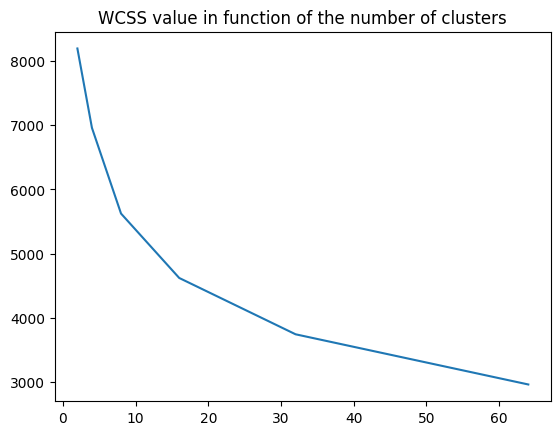

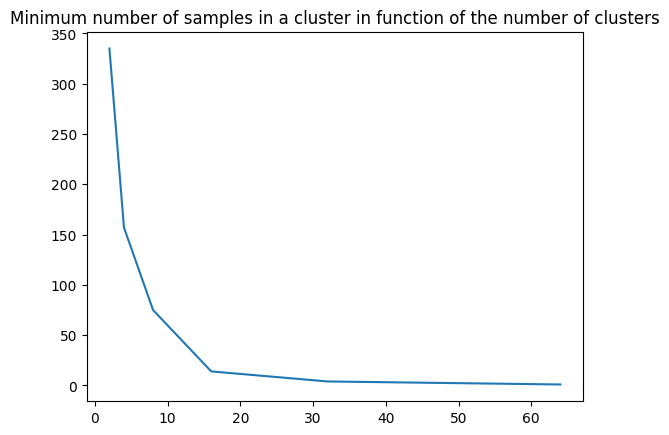

In [9]:
plt.plot([2,4,8,16,32,64],l_wcss)
plt.title("WCSS value in function of the number of clusters")
plt.show()
plt.plot([2,4,8,16,32,64],l_mincount)
plt.title("Minimum number of samples in a cluster in function of the number of clusters")
plt.show()

In order to not have too many additional attributes, and avoid overfitting, we choose a number of 8 clusters.

In [10]:
kmeans = KMeans(n_clusters=8, init='k-means++')
kmeans.fit(X_train_prepared)
dataset_train_preprocessed["cluster"]=kmeans.predict(X_train_prepared)
dataset_test_preprocessed["cluster"]=kmeans.predict(X_test_prepared)

In [11]:
cat_cols.append("cluster")
training_features.append("cluster")
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(dataset_train_preprocessed[training_features])
X_test_prepared = preprocessor.transform(dataset_test_preprocessed[training_features])

y_test = dataset_test_preprocessed[target_feature]
y_train = dataset_train_preprocessed[target_feature]

y_test_classification = np.array(dataset_test_preprocessed[target_feature_classification]).reshape(len(dataset_test_preprocessed,))
y_train_classification = np.array(dataset_train_preprocessed[target_feature_classification]).reshape(len(dataset_train_preprocessed,))

In [12]:
training_features_processed=['director_quality', 'highimpact genre']+[f"cluster_{i}" for i in range(8)]+num_cols

## Regression

### Method and references

In a first time, we will see which performance we can reach with regression ensemble trees. The types of of models explored are: 
- Decision Trees
- Random Forests
- Gradient Boosting Decision Trees
- Adaboost

For each target numerical attribute, to have a reference in terms of performance, we will compare the results to :
- a naiv baseline being the average value of a that attribute in the training dataset
- an OLS regressor

Besides, we will compare the multiple targets decision trees from scikit learn with the typical single target decision trees.

In [13]:
plt.rc('font', size=10)

First, we visualize how much the different targets are correlated :

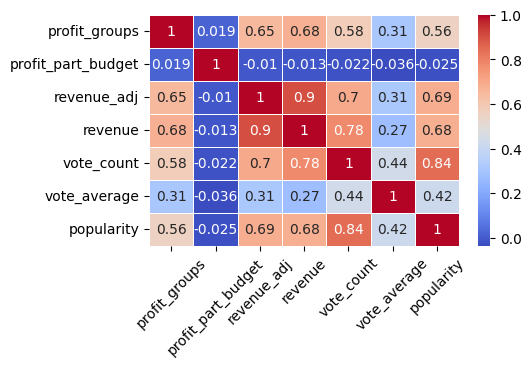

In [14]:
correlation_matrix = y_train.corr()

plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45)
# plt.title('Correlation Matrix between the different targets')
plt.show()

As expected, the revenue and adjusted revenue are significantly correlated, but it also justifies removing the vote_count attribute from the training attributes given its important (and expected) correlation with the revenue.

The popularity being correlated to the vote_count, removing it is as well justified. 

Removing the vote_average may seem less necessary, but we want to respect the situtation in which an onvestor has no information on how the movie will be received by the public.

We create a dictionnary in which we save the results for the different types of regressors and the baseline models:

In [15]:
# Do not run this cell again when changing the type of ensembles, otherwise, you will loose you results.
dic_median={}
dic_mean={}
dic_accuracy={}

In [16]:
# Do not run this cell again when changing the type of ensembles, otherwise, you will loose you rresults.
baseline_model_OLS=LinearRegression()
baseline_model_OLS.fit(X_train_prepared,y_train)

dic_res={}

res_mean=y_train.mean()
res_mean[0]=res_mean[0].round()
res_OLS=baseline_model_OLS.predict(X_test_prepared)
res_OLS[:,0]=res_OLS[:,0].round()

dic_mean["Baseline mean"]=mean_squared_error([res_mean]*len(y_test),y_test,multioutput='raw_values')
dic_mean["Baseline OLS"]=mean_squared_error(res_OLS,y_test,multioutput='raw_values')

dic_median["Baseline mean"]=np.median(np.abs(np.array([res_mean]*len(y_test))-y_test),axis=0)
dic_median["Baseline OLS"]=np.median(np.abs(res_OLS-y_test),axis=0)


Similarly, we will save every estimator and feature importances in a dictionnary.

In [17]:
# Do not run this cell again when changing the type of ensembles, otherwise, you will loose you rresults.
dic_best_estimators_ensembles={}    #(dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi)

### Gridsearch

In [18]:
FOLDER_MODELS="saved_models_bis"
if not os.path.exists(FOLDER_MODELS):
    os.mkdir(FOLDER_MODELS)

Choose the type of regressor to evaluate (to plot the final comparison, if you want all results, you must have trie all of them):

In [47]:
# "Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost"
# Type_of_tree_ensemble="Decision Tree" 
# Type_of_tree_ensemble="Random Forest" 
# Type_of_tree_ensemble="Gradient Boosting" 
Type_of_tree_ensemble="K-Neighbors"


if Type_of_tree_ensemble == "Decision Tree":
    tree_regressor=DecisionTreeRegressor(random_state=0,criterion="friedman_mse")
elif Type_of_tree_ensemble == "Random Forest":
    tree_regressor=RandomForestRegressor(random_state=0,n_jobs=16,criterion="friedman_mse")
elif Type_of_tree_ensemble=="Gradient Boosting":
    tree_regressor= GradientBoostingRegressor(random_state=0,criterion="friedman_mse")
elif Type_of_tree_ensemble=="Adaboost":
    tree_regressor= AdaBoostRegressor(random_state=0)
elif Type_of_tree_ensemble=="K-Neighbors":  # We keep the same synthax to reduce the number of variables and make code smaller even though it is not a tree ensemble regressor.
    tree_regressor=KNeighborsRegressor(n_jobs=16)

Then, we choose appropriate ranges of hyperparameters to test for the grid search, with specific parameters depending on the chosen type of model.

In [48]:
param_grids={

    "Decision Tree": {
        'max_depth': [5, 10,20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":[None,"sqrt"]},
    "Random Forest": {
        "n_estimators":[50,100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":[None,"sqrt"]},
    "Gradient Boosting": {
        "n_estimators":[20,50],
         "learning_rate":[0.1,0.5],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":[None,"sqrt"]},
    "Adaboost": {
        "n_estimators":[20,50],
         "learning_rate":[0.1,0.5,1],
        'loss': ["linear","square"]},
    "K-Neighbors": {
        "weights":["uniform", "distance"],
         "n_neighbors":[2,5,10,50]}}

The use of "neg_mean_squared_error" enables to have best estimators chosen accoriding to their performance in terms of Mean Squared Error (which is the metric used for splitting).

In [49]:
if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
    if os.path.exists(FOLDER_MODELS+"/"+Type_of_tree_ensemble+' multi.pkl'):
        # load if it exists
        with open(FOLDER_MODELS+'/'+Type_of_tree_ensemble+' multi.pkl', 'rb') as f:
            multi_target_dt = pickle.load(f)
        params=multi_target_dt.get_params()
        params={key: params[key] for key in list(param_grids[Type_of_tree_ensemble].keys()) if key in params}
        multi_target_fi=multi_target_dt.feature_importances_
        print("The best hyperparameters combination for the multi-target decision tree is : ",params)
    else:
        grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grids[Type_of_tree_ensemble], cv=5, scoring='neg_mean_squared_error',verbose=2)
        grid_search.fit(X_train_prepared, y_train)
        multi_target_dt=grid_search.best_estimator_
        multi_target_fi=multi_target_dt.feature_importances_
        # save otherwise
        with open(FOLDER_MODELS+"/"+Type_of_tree_ensemble+' multi.pkl','wb') as f:
            pickle.dump(multi_target_dt,f)


        print("The best hyperparameters combination for the multi-target decision tree is : ",grid_search.best_params_)

In [50]:
dic_single_target_dt={}     # saving of the best estimator per target
dic_single_target_fi={}     # saving of the feature importances
for target in y_train.columns:
    if os.path.exists(FOLDER_MODELS+'/'+Type_of_tree_ensemble+' '+target+'.pkl'):
        # load
        with open(FOLDER_MODELS+'/'+Type_of_tree_ensemble+' '+target+'.pkl', 'rb') as f:
            target_dt = pickle.load(f)
        dic_single_target_dt[target]=target_dt
        params=target_dt.get_params()
        params={key: params[key] for key in list(param_grids[Type_of_tree_ensemble].keys()) if key in params}
        if Type_of_tree_ensemble!="K-Neighbors":
            dic_single_target_fi[target]=target_dt.feature_importances_
        print("For "+target+", the best hyperparameters combination is : ",params)
    else:
        
        grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grids[Type_of_tree_ensemble], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_prepared, y_train[target])
        dic_single_target_dt[target]=grid_search.best_estimator_
        if Type_of_tree_ensemble!="K-Neighbors":
            dic_single_target_fi[target]=grid_search.best_estimator_.feature_importances_
        # save
        with open(FOLDER_MODELS+'/'+Type_of_tree_ensemble+' '+target+'.pkl','wb') as f:
            pickle.dump(grid_search.best_estimator_,f)

        print("For "+target+", the best hyperparameters combination is : ",grid_search.best_params_)

For profit_groups, the best hyperparameters combination is :  {'weights': 'distance', 'n_neighbors': 50}
For profit_part_budget, the best hyperparameters combination is :  {'weights': 'uniform', 'n_neighbors': 50}
For revenue_adj, the best hyperparameters combination is :  {'weights': 'distance', 'n_neighbors': 10}
For revenue, the best hyperparameters combination is :  {'weights': 'distance', 'n_neighbors': 10}
For vote_count, the best hyperparameters combination is :  {'weights': 'uniform', 'n_neighbors': 10}
For vote_average, the best hyperparameters combination is :  {'weights': 'distance', 'n_neighbors': 50}
For popularity, the best hyperparameters combination is :  {'weights': 'distance', 'n_neighbors': 50}


### Feature importance

In [51]:
if Type_of_tree_ensemble!="K-Neighbors":
    plt.figure(figsize=(12, 6))
    if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
        features_importances_single=np.array([dic_single_target_fi[target] for target in y_train.columns]+[multi_target_fi])
    else:
        features_importances_single=np.array([dic_single_target_fi[target] for target in y_train.columns])

    features_importances_single=pd.DataFrame(features_importances_single,columns=training_features_processed)

    if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
        features_importances_single.index=list(y_train.columns)+["multi-target"]
    else:
        features_importances_single.index=list(y_train.columns)
    features_importances_single=features_importances_single.transpose()
    norm=LogNorm(vmin=features_importances_single[features_importances_single>0].min().min(), vmax=features_importances_single.max().max())

    sns.heatmap(features_importances_single, annot=True, cmap='coolwarm',norm=norm, linewidths=0.5)
    plt.title('Feature importance by target')
    plt.show()

We see that some of feature's importances among the different targets and within a single target varies greatly. It is interesting to note that the key feature (the one with the significantly highest importance) is different depending on the target. The runtime seems to be the only feature that is always important. On the contrary, some features like the budget that might have been thought to be of high importance is always has a low feature importance. A popular and profitable film is thus not really budget dependant.

In [52]:
if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
    dic_best_estimators_ensembles[Type_of_tree_ensemble]=(dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi)
else:
    dic_best_estimators_ensembles[Type_of_tree_ensemble]=(dic_single_target_dt,features_importances_single,_,_)

### First plot of the results

We display the normalized MSE by target and model. The normalization is important to compare the performance of the model among different targets, given that the targets are not normalized.

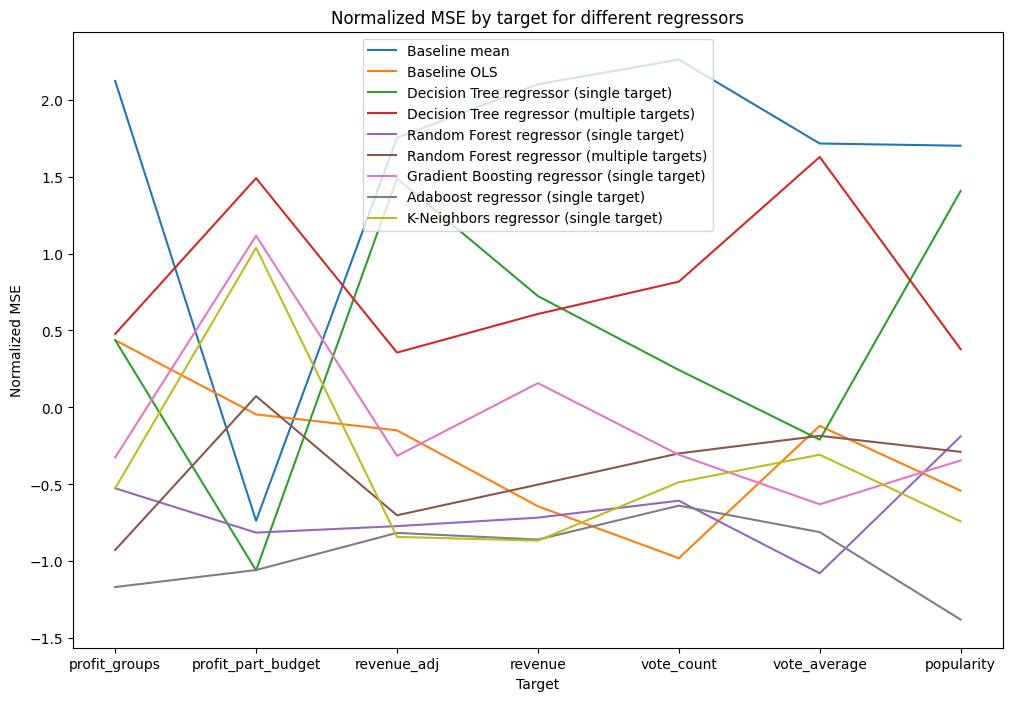

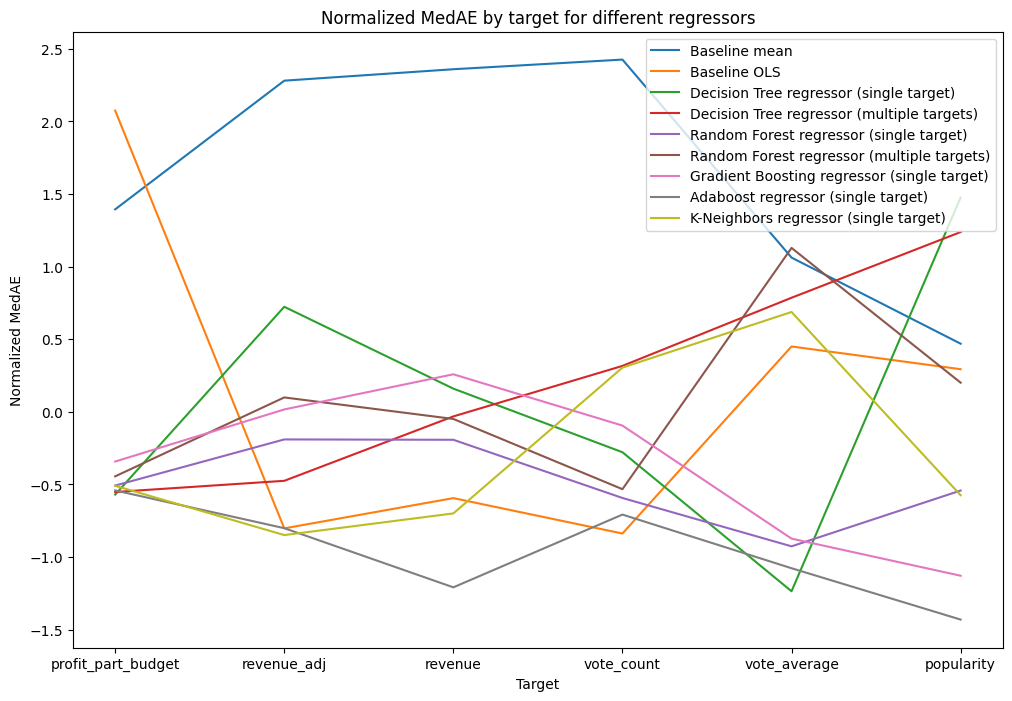

In [53]:

res=np.array([dic_single_target_dt[target].predict(X_test_prepared) for target in y_test.columns]).transpose()
res[:,0]=res[:,0].round()

dic_mean[Type_of_tree_ensemble+" regressor (single target)"]=mean_squared_error(res,y_test,multioutput='raw_values')
if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
    res_multi=multi_target_dt.predict(X_test_prepared)
    res_multi[:,0]=res_multi[:,0].round()
    dic_mean[Type_of_tree_ensemble+" regressor (multiple targets)"]=mean_squared_error(res_multi,y_test,multioutput='raw_values')

dic_median[Type_of_tree_ensemble+" regressor (single target)"]=np.median(np.abs(res-y_test),axis=0)
if Type_of_tree_ensemble in ["Decision Tree", "Random Forest"]:
    dic_median[Type_of_tree_ensemble+" regressor (multiple targets)"]=np.median(np.abs(res_multi-y_test),axis=0)


df_mean=pd.DataFrame(dic_mean)
df_mean_norm=df_mean.transpose()
df_mean_norm=(df_mean_norm-df_mean_norm.mean())/df_mean_norm.std()
df_mean_norm=df_mean_norm.transpose()



df_median=pd.DataFrame(dic_median)
df_median_norm=df_median.transpose()
df_median_norm=(df_median_norm-df_median_norm.mean())/df_median_norm.std()
df_median_norm=df_median_norm.transpose()

plt.figure(figsize=(12,8))
for model in df_mean_norm.columns:
    plt.plot(y_test.columns,df_mean_norm[model],label=model)

plt.ylabel('Normalized MSE')
plt.xlabel('Target')
plt.title('Normalized MSE by target for different regressors')
plt.legend()
plt.show()


plt.figure(figsize=(12,8))
for model in df_median_norm.columns:
    plt.plot(y_test.columns,df_median_norm[model],label=model)

plt.ylabel('Normalized MedAE')
plt.xlabel('Target')
plt.title('Normalized MedAE by target for different regressors')
plt.legend()
plt.show()

<span style="color:red">Before going further, you are invited to relaunch the code for each type of models.</span>

We save the MedAE and MEAN summary df.

In [54]:
# metric="median" #"mean", "median"

# def metricf (array): 
#     if metric=="median":
#         return(np.median(array))
#     if metric=="mean":
#         return(np.mean(array))

# dic_median={}
# for type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost", "Baseline OLS","Baseline mean"]:
#     if type_ensemble in ["Decision Tree", "Random Forest","Gradient Boosting", "Adaboost"]:
#         dic_median[type_ensemble+" regressor (single target)"]=[]
#         if type_ensemble in ["Decision Tree", "Random Forest"]:
#                 dic_median[type_ensemble+" regressor (multiple targets)"]=[]
#     else:
#         dic_median[type_ensemble]=[]

# for target in y_test.columns:
#     index_target=list(y_test.columns).index(target)
    

#     for type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost", "Baseline OLS","Baseline mean"]:

#         if type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost"]:

#             dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]
            

#         if type_ensemble in ["Decision Tree", "Random Forest","Gradient Boosting", "Adaboost"]:
#             dic_median[type_ensemble+" regressor (single target)"].append(metricf(np.array((dic_single_target_dt[target].predict(X_test_prepared)-y_test[target])**2)))
            
#         if type_ensemble in ["Decision Tree", "Random Forest"]:
#             dic_median[type_ensemble+" regressor (multiple targets)"].append(metricf(np.array((multi_target_dt.predict(X_test_prepared)[:,index_target]-y_test[target])**2)))

#         if type_ensemble=="Baseline OLS":
#             dic_median[type_ensemble].append(metricf(np.array((baseline_model_OLS.predict(X_test_prepared)[:,index_target]-y_test[target])**2)))

#         if type_ensemble=="Baseline mean":
#             dic_median[type_ensemble].append(metricf(np.array((y_test[target]-np.mean(y_train[target]))**2)))

# df_median=pd.DataFrame(dic_median)

In [55]:
df_median.index=y_test.columns
df_mean.index=y_test.columns
df_mean=df_mean.reindex(sorted(df_mean.columns), axis=1)
df_median=df_median.reindex(sorted(df_median.columns), axis=1)
df_mean.to_csv("res_mean_reg.csv")
df_median.to_csv("res_median_reg.csv")


In [56]:
df_mean=pd.read_csv("res_mean_reg.csv")
df_median=pd.read_csv("res_median_reg.csv")
df_mean=df_mean.reindex(sorted(df_mean.columns), axis=1)
df_median=df_median.reindex(sorted(df_median.columns), axis=1)
df_mean=df_mean.drop("Unnamed: 0",axis=1)
df_median=df_median.drop("Unnamed: 0",axis=1)
df_mean.index=y_test.columns
df_median.index=y_test.columns

In [57]:
list_abbrev=["Ada","OLS","BL","DTm","DTs","GB","KN","RFm","RFs"]

l_recap=[]
for target in df_mean.index:
    l=[]
    l.append(target)
    l.append(list_abbrev[list(df_mean.columns).index(df_mean.transpose()[df_mean.transpose()[target]==df_mean.transpose().min()[target]].index[0])])
    l.append(df_mean.transpose().min()[target])
    l.append(df_mean.loc[target]["Baseline OLS"])
    l.append(df_mean.loc[target]["Baseline mean"])
    l.append(list_abbrev[list(df_mean.columns).index(df_median.transpose()[df_median.transpose()[target]==df_median.transpose().min()[target]].index[0])])
    l.append(df_median.transpose().min()[target])
    l.append(df_median.loc[target]["Baseline OLS"])
    l.append(df_median.loc[target]["Baseline mean"])
    # print(target,list_abbrev[list(df_mean.columns).index(df_mean.transpose()[df_mean.transpose()[target]==df_mean.transpose().min()[target]].index[0])])
    # print(target,list_abbrev[list(df_median.columns).index(df_mean.transpose()[df_median.transpose()[target]==df_median.transpose().min()[target]].index[0])])
    print(l)
    l_recap.append(l)

df_recap=pd.DataFrame(l_recap)
df_recap.to_csv("raw_recap.csv")

['profit_groups', 'Ada', 0.7875647668393783, 0.9948186528497408, 1.212435233160622, 'Ada', 1.0, 1.0, 1.0]
['profit_part_budget', 'DTs', 535.7105008465501, 8371.492418135369, 3026.691151848436, 'DTs', 1.5421818277920318, 65.66980896, 49.17590425065482]
['revenue_adj', 'KN', 4.213968226889541e+16, 5.4691632503312456e+16, 8.916535664613413e+16, 'KN', 60234665.35377157, 61675970.83253901, 157757184.1003378]
['revenue', 'KN', 4.858222645142896e+16, 5.3159017151107656e+16, 1.0922437036455342e+17, 'Ada', 42378880.58544304, 57993523.0, 133047507.12534308]
['vote_count', 'OLS', 1045725.7772020726, 1045725.7772020726, 2215628.072912947, 'OLS', 383.0, 383.0, 665.4967978042087]
['vote_average', 'RFs', 0.6429629192460317, 0.6907101661800719, 0.7821674046284891, 'DTs', 0.549090909090908, 0.6218750000000002, 0.6483074107959741]
['popularity', 'Ada', 17.49101218095153, 18.52188436524024, 21.279452303400006, 'Ada', 0.9092397666666672, 1.0566055, 1.0716084784995423]


In [58]:
# .to_string(float_format=lambda x: f'{x:.2e}')
# df_recap=pd.read_csv(io.StringIO(df_recap), delim_whitespace=True)
df_recap.columns=["Target","Type","Score","OLS","BL","Type","Score","OLS","BL"]
df_recap.to_csv("recap_tab.csv",sep="&",float_format='%.2e')

In [59]:
df_recap

,Target,Type,Score,OLS,BL,Type,Score,OLS,BL
0,profit_groups,Ada,7.875648e-01,9.948187e-01,1.212435e+00,Ada,1.000000e+00,1.000000e+00,1.000000e+00
1,profit_part_budget,DTs,5.357105e+02,8.371492e+03,3.026691e+03,DTs,1.542182e+00,6.566981e+01,4.917590e+01
2,revenue_adj,KN,4.213968e+16,5.469163e+16,8.916536e+16,KN,6.023467e+07,6.167597e+07,1.577572e+08
3,revenue,KN,4.858223e+16,5.315902e+16,1.092244e+17,Ada,4.237888e+07,5.799352e+07,1.330475e+08
4,vote_count,OLS,1.045726e+06,1.045726e+06,2.215628e+06,OLS,3.830000e+02,3.830000e+02,6.654968e+02
5,vote_average,RFs,6.429629e-01,6.907102e-01,7.821674e-01,DTs,5.490909e-01,6.218750e-01,6.483074e-01
6,popularity,Ada,1.749101e+01,1.852188e+01,2.127945e+01,Ada,9.092398e-01,1.056606e+00,1.071608e+00


### Computation of the median and models' performances comparision among the different targets

Displaying the distribution of squared error by target and by model is necessary in order to evaluate the risks that might imply the choice of model. Indeed, a model having great variability will be dangerous for the investors.

C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3962692309.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[index_target//2,index_target%2].set_xticklabels(["Ada","OLS","BL","DTm","DTs","GB","RFm","RFs","KN"])
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3962692309.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[index_target//2,index_target%2].set_xticklabels(["Ada","OLS","BL","DTm","DTs","GB","RFm","RFs","KN"])
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3962692309.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[index_target//2,index_target%2].set_xticklabels(["Ada","OLS","BL","DTm","DTs","GB","RFm","RFs","KN"])
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3962692309.py:32: UserWarning: set_

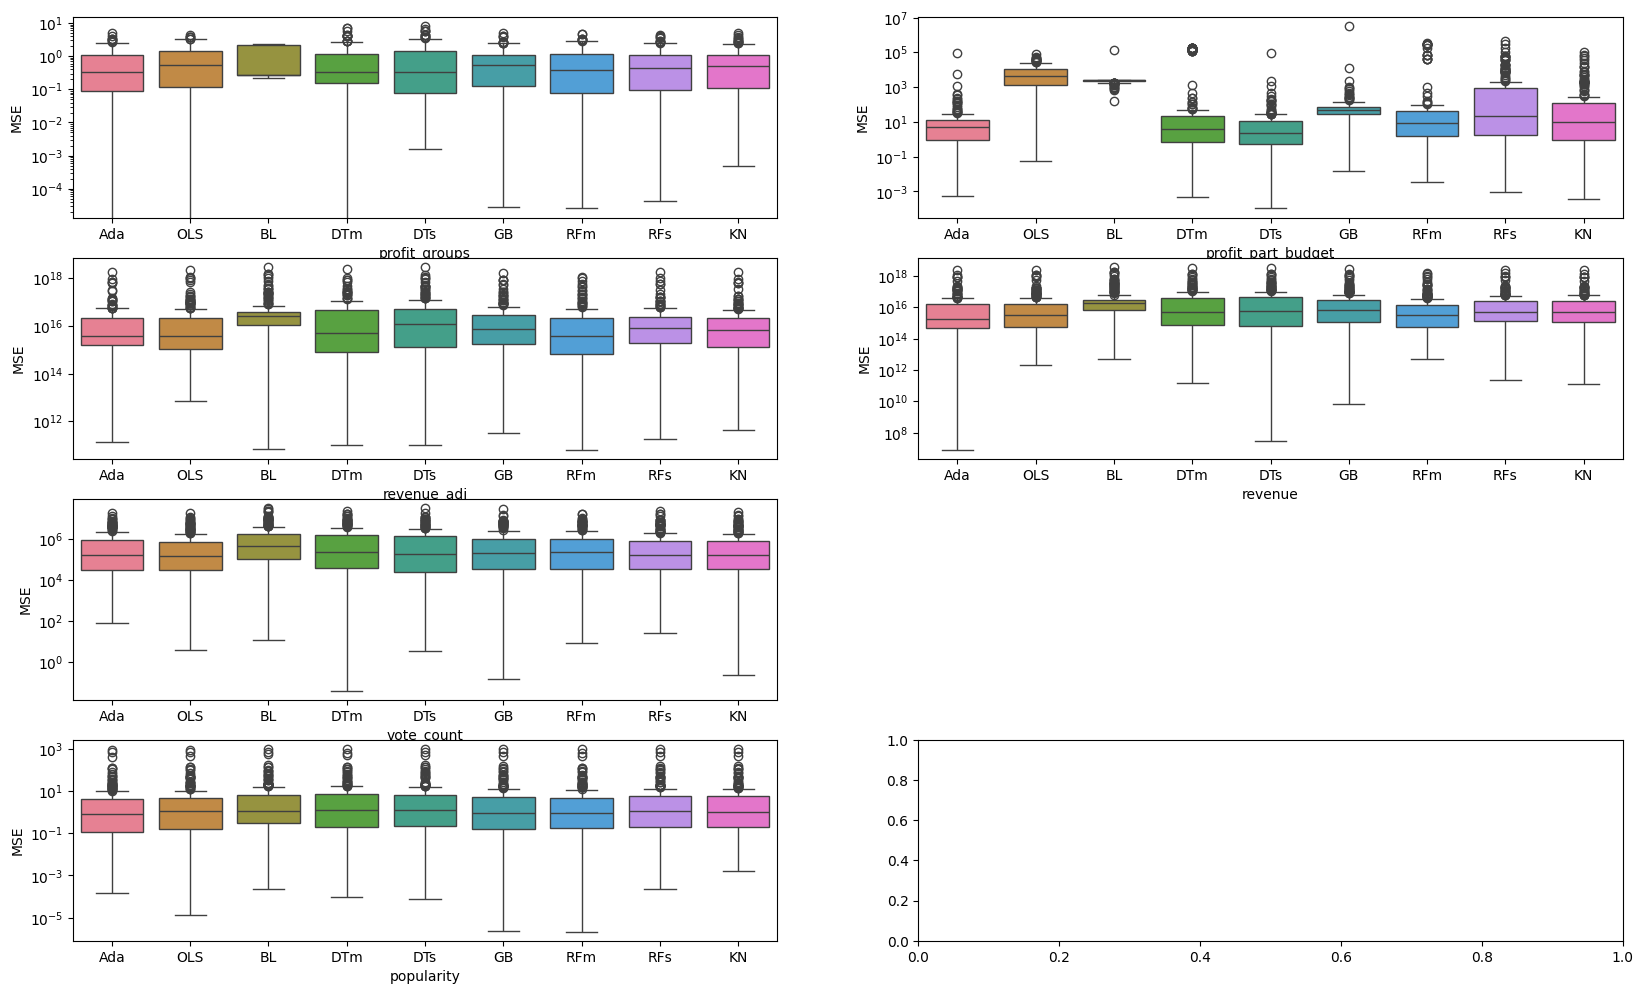

In [60]:
fig, axes = plt.subplots(nrows=len(y_test.columns)//2 +1, ncols=2, figsize=(20, 12))

# target="vote_count"    #"revenue", "revenue_adj", "vote_count","vote_average","popularity"
for target in y_test.columns:
    index_target=list(y_test.columns).index(target)

    dic_boxplot={}

    for type_ensemble in ["Adaboost","Baseline OLS","Baseline mean","Decision Tree","Gradient Boosting", "Random Forest","K-Neighbors"]:

        if type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost","K-Neighbors"]:

            dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]

        if type_ensemble in ["Decision Tree", "Random Forest"]:
            dic_boxplot[type_ensemble+" (multiple targets)"]=np.array((multi_target_dt.predict(X_test_prepared)[:,index_target]-y_test[target])**2)

        if type_ensemble in ["Decision Tree", "Random Forest","Gradient Boosting", "Adaboost","K-Neighbors"]:
            dic_boxplot[type_ensemble+" (single_target)"]=np.array((dic_single_target_dt[target].predict(X_test_prepared)-y_test[target])**2)
            
        if type_ensemble=="Baseline OLS":
            dic_boxplot[type_ensemble]=np.array((baseline_model_OLS.predict(X_test_prepared)[:,index_target]-y_test[target])**2)

        if type_ensemble=="Baseline mean":
            dic_boxplot[type_ensemble]=np.array((y_test[target]-np.mean(y_train[target]))**2)

    sns.set_palette(sns.color_palette("hls", 8))
    df_boxplot=pd.DataFrame(dic_boxplot)
    df_boxplot=df_boxplot.reindex(sorted(df_boxplot.columns), axis=1)
    sns.boxplot(data=df_boxplot,ax=axes[index_target//2,index_target%2])
    
    axes[index_target//2,index_target%2].set_xticklabels(["Ada","OLS","BL","DTm","DTs","GB","RFm","RFs","KN"])
    # plt.xticks(rotation=90)
    axes[index_target//2,index_target%2].set_yscale('log')
    axes[index_target//2,index_target%2].set_xlabel(target)
    axes[index_target//2,index_target%2].set_ylabel("MSE")
axes[2, 1].remove()
plt.show()

For a specific target, we can now plot a metric by model:

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Decision Tree (single_target)'),
  Text(1, 0, 'Decision Tree (multiple targets)'),
  Text(2, 0, 'Random Forest (single_target)'),
  Text(3, 0, 'Random Forest (multiple targets)'),
  Text(4, 0, 'Gradient Boosting (single_target)'),
  Text(5, 0, 'Adaboost (single_target)'),
  Text(6, 0, 'Baseline OLS'),
  Text(7, 0, 'Baseline Mean'),
  Text(8, 0, 'K-Neighbors (single_target)')])

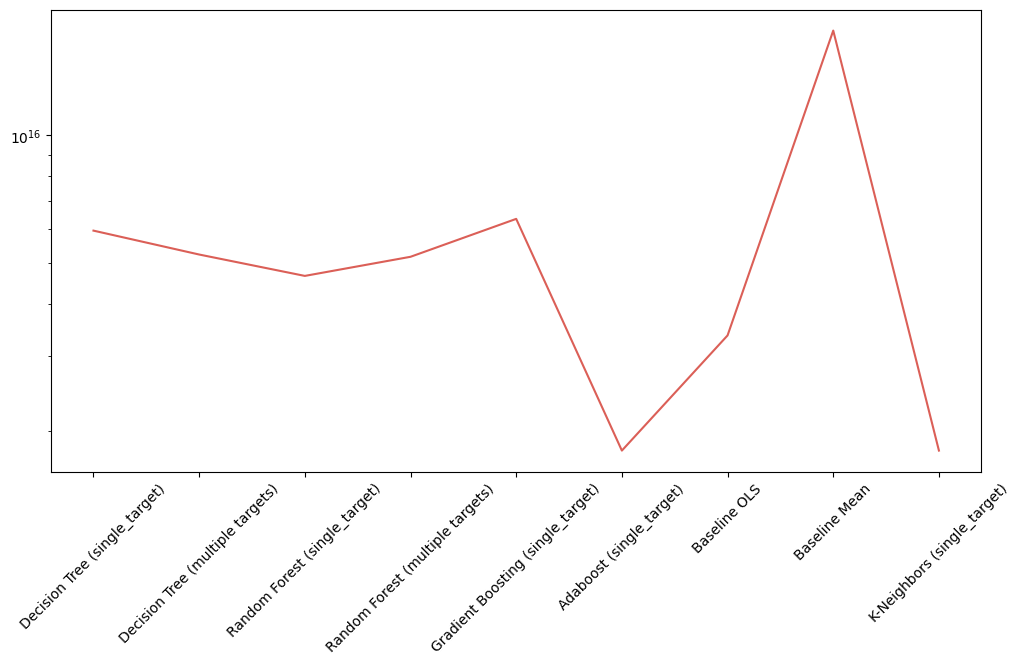

In [61]:
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
fig = plt.figure(figsize=(12,6))

metric="median" #"mean", "median"

def metricf (array): 
    if metric=="median":
        return(np.median(array))
    if metric=="mean":
        return(np.mean(array))

target="revenue"
index_target=list(y_test.columns).index(target)

dic_boxplot={}

for type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost", "Baseline OLS","Baseline Mean","K-Neighbors"]:

    if type_ensemble in ["Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost"]:

        dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]

    if type_ensemble in ["Decision Tree", "Random Forest","Gradient Boosting", "Adaboost","K-Neighbors"]:
        dic_boxplot[type_ensemble+" (single_target)"]=metricf(np.array((dic_single_target_dt[target].predict(X_test_prepared)-y_test[target])**2))
        
    if type_ensemble in ["Decision Tree", "Random Forest"]:
        dic_boxplot[type_ensemble+" (multiple targets)"]=metricf(np.array((multi_target_dt.predict(X_test_prepared)[:,index_target]-y_test[target])**2))

    if type_ensemble=="Baseline OLS":
        dic_boxplot[type_ensemble]=metricf(np.array((baseline_model_OLS.predict(X_test_prepared)[:,index_target]-y_test[target])**2))

    if type_ensemble=="Baseline Mean":
        dic_boxplot[type_ensemble]=metricf(np.array((y_test[target]-np.mean(y_train[target]))**2))

sns.set_palette(sns.color_palette("hls", 8))
df_metric=pd.DataFrame(dic_boxplot,index=[0])
plt.plot(df_metric.columns,df_metric.iloc[0])
plt.yscale("log")
plt.xticks(rotation=45)

We create a dataframe showing the median of squared error by model and target in order to create later heatmaps for both metrics (mean and median).

After saving the two dataframes summarizing the performance in terms of average and median squared error, we can plot heatmaps of those MSE metrics by target. Thus, the closer the colour is to blue, the best the performance.

[]

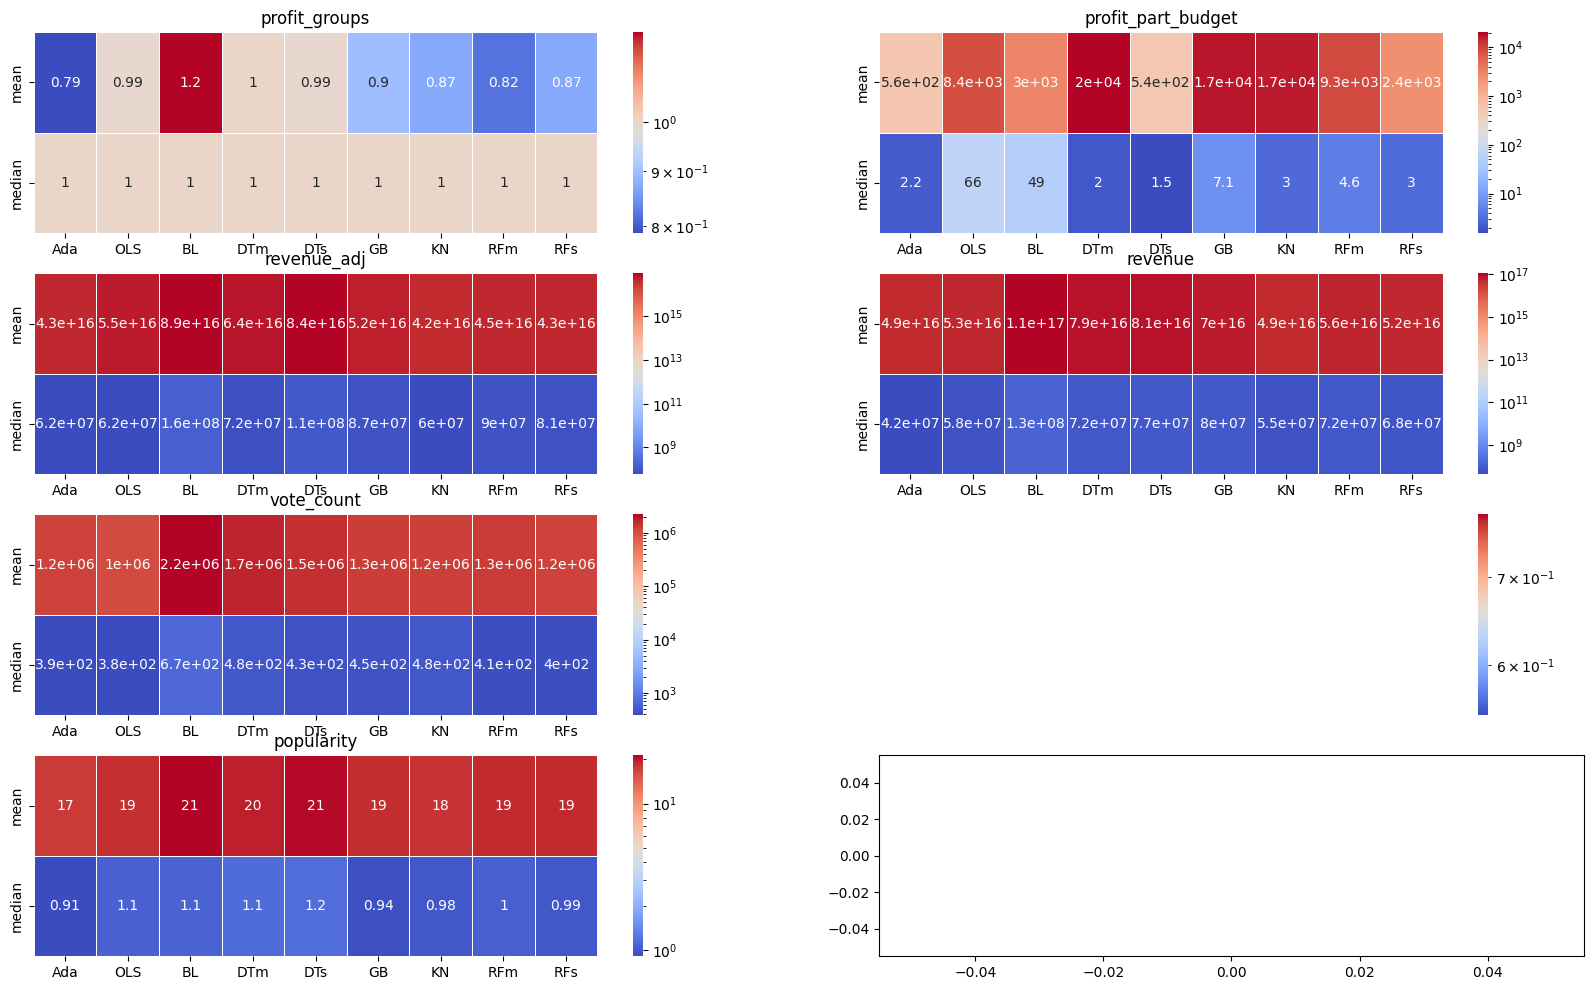

In [62]:
fig, axes = plt.subplots(nrows=len(y_test.columns)//2 +1, ncols=2, figsize=(20, 12))
i=0
for target in y_test.columns:
    loc_mean=pd.DataFrame(df_mean.loc[target]).transpose()
    loc_mean.index=["mean"]
    loc_median=pd.DataFrame(df_median.loc[target]).transpose()
    loc_median.index=["median"]
    concat_df=pd.concat([loc_mean,loc_median])
    norm=LogNorm(vmin=concat_df[concat_df!=0].min().min(), vmax=concat_df.max().max())
    sns.heatmap(concat_df, annot=True,xticklabels=["Ada","OLS","BL","DTm","DTs","GB","KN","RFm","RFs"], cmap='coolwarm',ax=axes[i//2,i%2], linewidths=0.5,norm=norm)
    axes[i//2,i%2].set_title(target)
    i+=1
axes[2, 1].remove()
plt.plot()



Clearly, the median of the squared error is significantly lower than the MSE. It can be explained by the presence of numerous outliers above the third quartile in the boxplots above.

Now, we decide to plot the feature importances if the different attributes for each of the targets and models.

C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\356994037.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\356994037.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\356994037.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\356994037.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_xticklabel

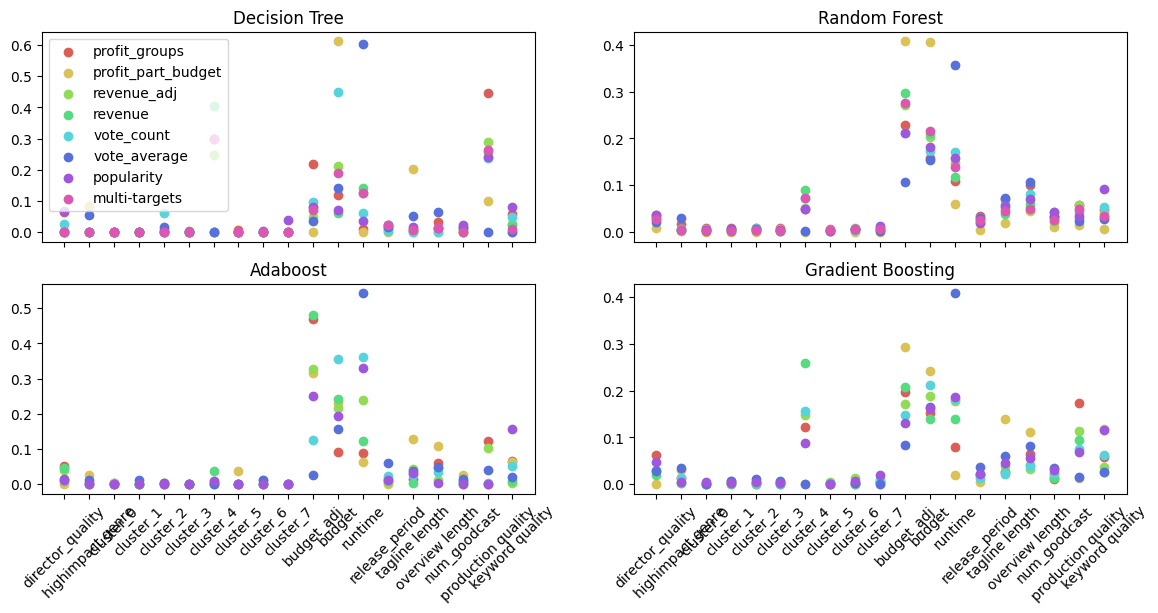

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))

# target="vote_count"    #"revenue", "revenue_adj", "vote_count","vote_average","popularity"
labels=list(y_test.columns)+["multi-targets"]
colors = sns.color_palette("hls", len(y_test.columns)+1)

i=0

for type_ensemble in ["Decision Tree", "Random Forest","Adaboost","Gradient Boosting"]:


    dic_single_target_dt,dic_single_target_fi,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]

    if type_ensemble in ["Decision Tree", "Random Forest"]:
        
            if type_ensemble=="Decision Tree":
                for target in y_train.columns:
                
                    index_target=list(y_test.columns).index(target)
                    axes[i//2,i%2].scatter(training_features_processed,dic_single_target_fi[target],color=colors[index_target], label=labels[index_target])
                axes[i//2,i%2].scatter(training_features_processed,multi_target_fi,color=colors[len(y_test.columns)], label=labels[len(y_test.columns)])
            else:
                for target in y_train.columns:
                    
                    index_target=list(y_test.columns).index(target)
                    axes[i//2,i%2].scatter(training_features_processed,dic_single_target_fi[target],color=colors[index_target])
                axes[i//2,i%2].scatter(training_features_processed,multi_target_fi,color=colors[len(y_test.columns)])
        

    if type_ensemble in ["Gradient Boosting", "Adaboost"]:
        for target in y_train.columns:
            index_target=list(y_test.columns).index(target)
            axes[i//2,i%2].scatter(training_features_processed,dic_single_target_fi[target],color=colors[index_target])
    
    if i==0:
        axes[i//2,i%2].legend()

    hide_tick_labels = [label if i//2==1 else '' for label in training_features_processed]
    axes[i//2,i%2].set_xticklabels(hide_tick_labels,rotation=45)

    axes[i//2,i%2].set_title(type_ensemble)

    i+=1

# for i, color in enumerate(colors):
#     plt.scatter(i, 0, color=color)


plt.show()
    

C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3809197380.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(y_test.columns,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3809197380.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(y_test.columns,rotation=45)


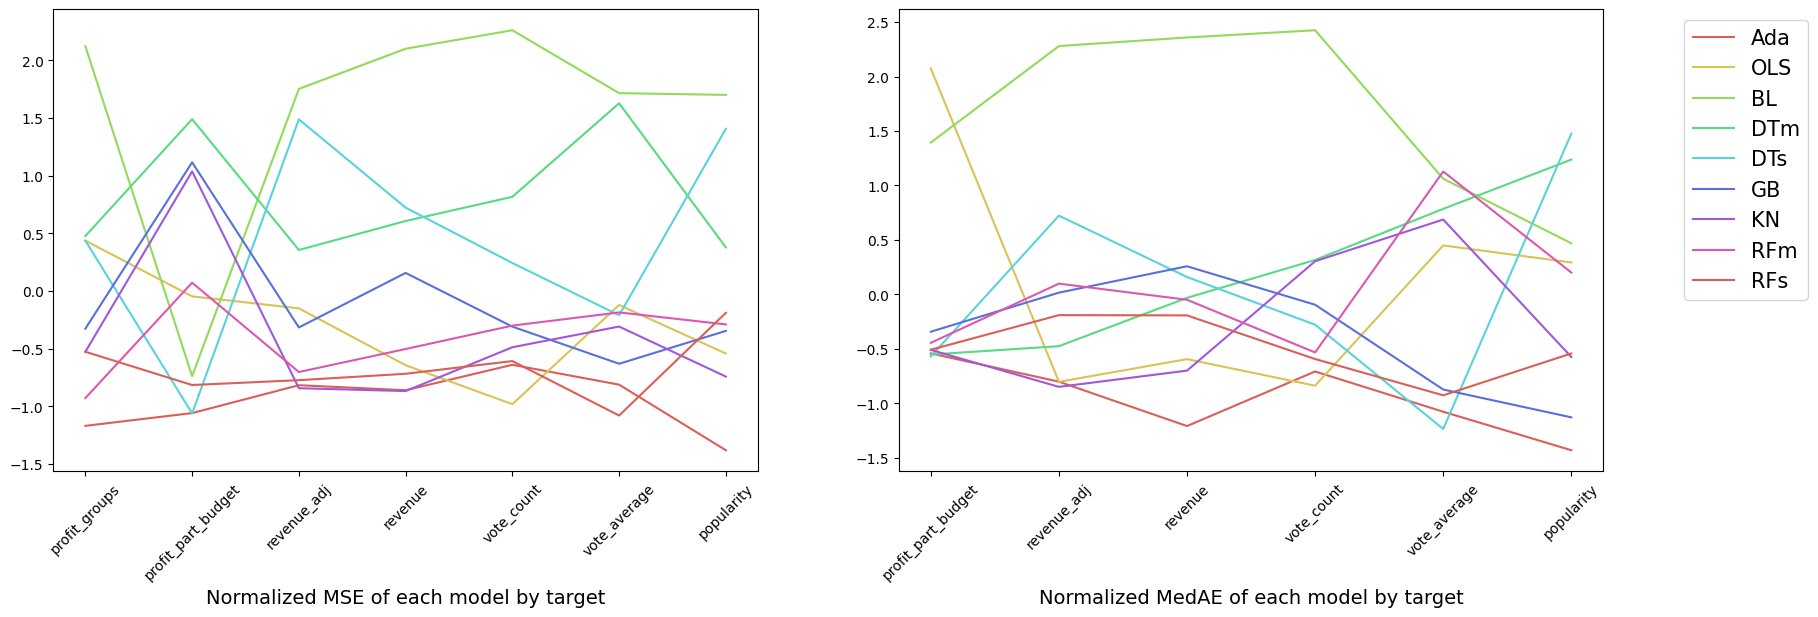

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.set_palette(sns.color_palette("hls", 8))
labels=["Ada","OLS","BL","DTm","DTs","GB","KN","RFm","RFs"]
plt.rc('font', size=15)
i=0
for model in df_mean.columns:
    df_res_temp=df_mean.transpose()
    df_res_temp=(df_res_temp-df_res_temp.mean())/df_res_temp.std()
    df_res_temp=df_res_temp.transpose()
    axes[0].plot(df_res_temp.index,df_res_temp[model],label=labels[i])
    
    i+=1
    
i=0
for model in df_median.columns:
    df_median_temp=df_median.transpose()
    df_median_temp=(df_median_temp-df_median_temp.mean())/df_median_temp.std()
    df_median_temp=df_median_temp.transpose()
    axes[1].plot(df_median_temp.index,df_median_temp[model],label=labels[i])
    
    i+=1

axes[0].set_xlabel("Normalized MSE of each model by target",fontsize=14)    
axes[1].set_xlabel("Normalized MedAE of each model by target",fontsize=14)

axes[0].set_xticklabels(y_test.columns,rotation=45)
axes[1].set_xticklabels(y_test.columns,rotation=45)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()
plt.rc('font', size=10)

C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\2197960656.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\2197960656.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\2197960656.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(hide_tick_labels,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\2197960656.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(hide_tick_labels,rotat

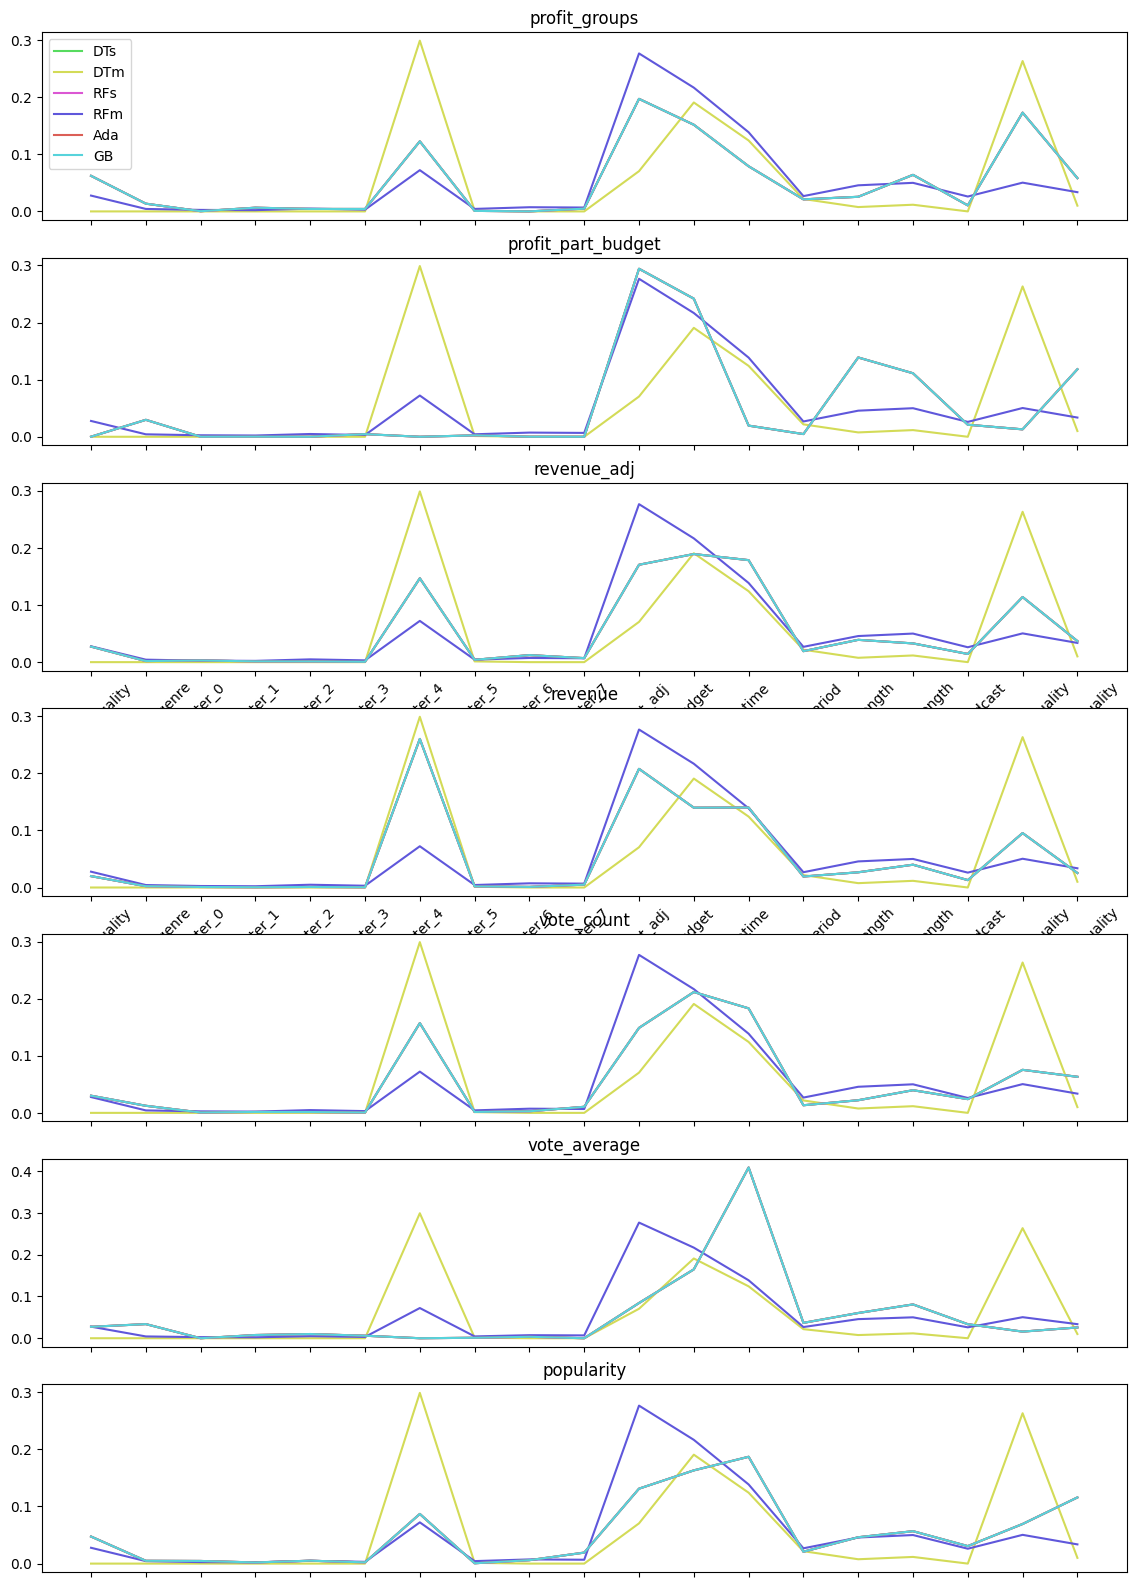

In [65]:
fig, axes = plt.subplots(nrows=len(y_test.columns), ncols=1, figsize=(14, 20))

# target="vote_count"    #"revenue", "revenue_adj", "vote_count","vote_average","popularity"
labels=["Ada","DTm","DTs","GB","RFm","RFs"]
colors = sns.color_palette("hls", len(labels))

# name_models=list(df_mean.columns)
# name_models.sort()
labels_simp=["DT","RF","Ada","GB"]
name_models=["Decision Tree", "Random Forest","Adaboost","Gradient Boosting"]

def aliasing(name_model,nb="", name_models=name_models,labels=labels_simp):
    return(labels[name_models.index(name_model)]+nb)
        

i=0
for target in y_test.columns:
    for type_ensemble in ["Decision Tree", "Random Forest","Adaboost","Gradient Boosting"]:



        dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]


        if type_ensemble in ["Decision Tree", "Random Forest"]:
            
                    
                axes[i].plot(training_features_processed,dic_single_target_fi[target],color=colors[labels.index(aliasing(type_ensemble,"s"))], label=aliasing(type_ensemble,"s"))
                axes[i].plot(training_features_processed,multi_target_fi,color=colors[labels.index(aliasing(type_ensemble,"m"))], label=aliasing(type_ensemble,"m"))
            

        if type_ensemble in ["Gradient Boosting", "Adaboost"]:
            axes[i].plot(training_features_processed,dic_single_target_fi[target],color=colors[labels.index(aliasing(type_ensemble))],label=aliasing(type_ensemble))
        
    if i==0:
        axes[i].legend()

    hide_tick_labels = [label if i//2==1 else '' for label in training_features_processed]
    axes[i].set_xticklabels(hide_tick_labels,rotation=45)

    axes[i].set_title(target)

    i+=1


plt.show()
    

[-0.3, -0.1, 0.1, 0.3]


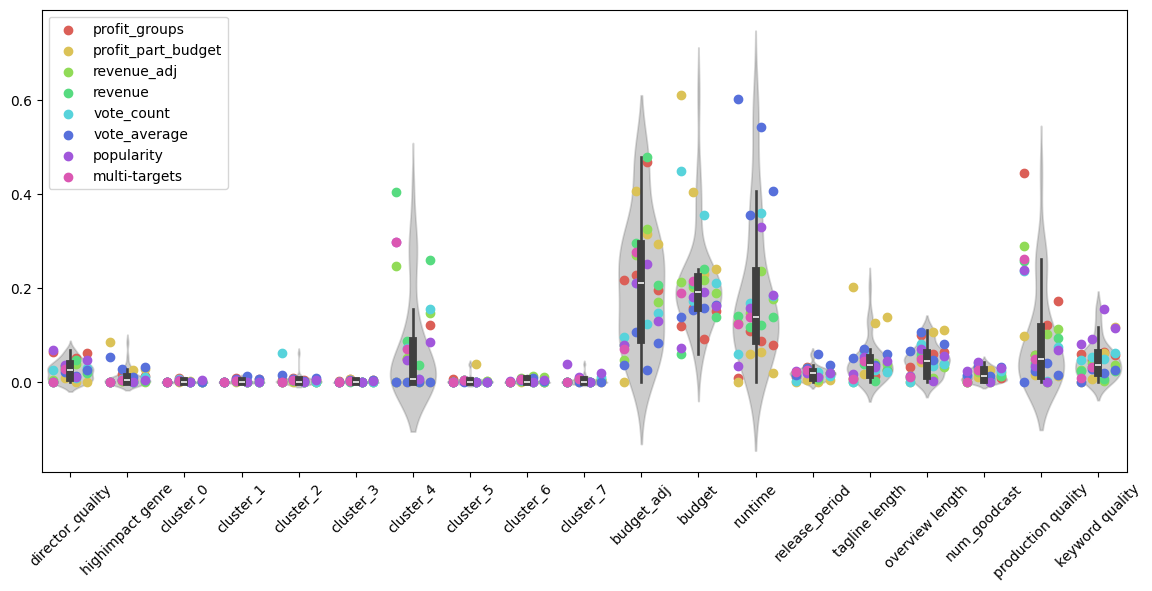

In [66]:
targets=y_test.columns

fig= plt.figure(figsize=(14, 6))


labels=list(targets)+["multi-targets"]
colors = sns.color_palette("hls", len(targets)+1)

jitter=[-0.3,-0.1,0.1,0.3]
print(jitter)
k=0

dict_boxplot={}
for feature in training_features_processed : 
    dict_boxplot[feature]=[]

for type_ensemble in ["Decision Tree", "Random Forest","Adaboost","Gradient Boosting","K-Neighbors"]:
    
    

    dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi = dic_best_estimators_ensembles[type_ensemble]

    for feature in training_features_processed:
        dict_boxplot[feature]+=list(features_importances_single.loc[feature].values)

    if type_ensemble in ["Decision Tree", "Random Forest"]:

        for i,feature in enumerate(training_features_processed):
            dict_boxplot[feature].append(multi_target_fi[i])

        if type_ensemble=="Decision Tree":
            for target in targets:
            
                index_target=list(targets).index(target)
                plt.scatter(np.arange(len(training_features_processed))+jitter[k],features_importances_single[target],color=colors[index_target], label=labels[index_target])
            plt.scatter(np.arange(len(training_features_processed))+jitter[k],multi_target_fi,color=colors[len(targets)], label=labels[len(targets)])
        else:
            for target in targets:
                
                index_target=list(targets).index(target)
                plt.scatter(np.arange(len(training_features_processed))+jitter[k],features_importances_single[target],color=colors[index_target])
            plt.scatter(np.arange(len(training_features_processed))+jitter[k],multi_target_fi,color=colors[len(targets)])
        

    if type_ensemble in ["Gradient Boosting", "Adaboost"]:
        for target in targets:
            index_target=list(targets).index(target)
            plt.scatter(np.arange(len(training_features_processed))+jitter[k],features_importances_single[target],color=colors[index_target])
            # print(dic_single_target_fi[target])
    
    k+=1

df_boxplot=pd.DataFrame(dict_boxplot)
sns.violinplot(data=df_boxplot,alpha=0.2,zorder=0,facecolor="black")
plt.legend()
plt.xticks(np.arange(len(training_features_processed)),training_features_processed,rotation=45)

# plt.title(type_ensemble)



plt.show()
    

## Performance comparison with dense Neural Network

In [67]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error


num_folds = 5
kf = KFold(n_splits=num_folds,random_state=0,shuffle=True)

mse_scores = []
medae_scores = []

train_mse_per_fold = []
test_mse_per_fold = []


initial_learning_rate = 0.0005
lr_reduction_factor = 0.5
epochs_to_reduce_lr = 10  # Reduce learning rate every 10 epochs

def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % epochs_to_reduce_lr == 0:
        return lr * lr_reduction_factor
    else:
        return lr


lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

ref=np.inf

# K fold implementation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_prepared)):
    X_train, X_test = X_train_prepared[train_index], X_train_prepared[test_index]  # Split features
    y_train_loc, y_test_loc = np.array(y_train)[train_index], np.array(y_train)[test_index]  # Split targets


    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, input_dim=19, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        # At the end we keep only two layers in order to satisfy the feature/weights criterion
        # tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(16, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    # We choose mape as a loss to avoid having unbalanced contribution of the different targets given that they have average values that are significatly different
    model.compile(loss='mape', optimizer=optimizer, metrics=['mse', 'mae', 'mape'])

    
    history=model.fit(X_train, y_train_loc, epochs=100, batch_size=16, verbose=0,validation_data=(X_test, y_test_loc), callbacks=[lr_scheduler_callback])  # Using batch_size=32 for faster training

    mse=mean_squared_error(model.predict(X_test),y_test_loc,multioutput='raw_values')

    predictions = model.predict(X_test)

    medae = np.median(np.abs(y_test_loc - predictions), axis=0)

    mse_scores.append(mse)
    medae_scores.append(medae)


    print("Mean Squared Error for fold "+str(i), mse)
    print("Median Absolute Error for fold "+str(i), medae)


mean_mse = np.mean(mse_scores,axis=0)
mean_medae = np.mean(medae_scores,axis=0)

print("Mean Squared Error (Mean over all folds):", mean_mse)
print("Median Absolute Error (Mean over all folds):", mean_medae)



c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error for fold 18 [3.62265374e+00 4.49366451e+05 8.27834856e+16 6.09222415e+16
 2.10089368e+06 1.28767075e+01 2.36262307e+00]
Median Absolute Error for fold 18 [1.90864584e+00 1.35079303e+00 9.59145780e+07 8.91621613e+07
 3.62025799e+02 3.55160275e+00 5.73708506e-01]


c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error for fold 18 [3.67423296e+00 8.75433318e+03 1.55675456e+17 1.06525301e+17
 2.56467939e+06 8.26215122e+00 3.17798239e+00]
Median Absolute Error for fold 18 [1.85408102e+00 1.52650994e+00 9.44438128e+07 8.31881645e+07
 4.77057165e+02 2.69641376e+00 6.10584030e-01]


c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error for fold 18 [3.29936329e+00 7.58833271e+05 1.40528666e+17 8.44715674e+16
 2.03164575e+06 9.08129309e+00 1.68685330e+00]
Median Absolute Error for fold 18 [1.05735234e+00 1.35695521e+00 8.05478656e+07 7.21086072e+07
 3.36808352e+02 2.89398298e+00 4.70669468e-01]


c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error for fold 18 [3.56557247e+00 1.51455159e+02 8.94820862e+16 5.02019505e+16
 1.78105057e+06 8.86625790e+00 1.85020319e+00]
Median Absolute Error for fold 18 [1.90585983e+00 1.40749555e+00 8.44911497e+07 8.50094633e+07
 4.24645895e+02 2.66656356e+00 5.13528392e-01]


c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error for fold 18 [3.29124683e+00 3.31498451e+06 1.62951908e+17 1.18182526e+17
 2.56554916e+06 9.81277315e+00 2.38818249e+00]
Median Absolute Error for fold 18 [1.14568469e+00 1.57612088e+00 7.82634433e+07 6.93778470e+07
 3.61696617e+02 2.94025550e+00 5.28315002e-01]
Mean Squared Error (Mean over all folds): [3.49061386e+00 9.06418004e+05 1.26284320e+17 8.40607172e+16
 2.20876371e+06 9.77983657e+00 2.29316889e+00]
Median Absolute Error (Mean over all folds): [1.57432474e+00 1.44357492e+00 8.67321699e+07 7.97692487e+07
 3.92446766e+02 2.94976371e+00 5.39361080e-01]


In [68]:
initial_learning_rate = 0.0005
lr_reduction_factor = 0.5
epochs_to_reduce_lr = 10


best_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_dim=19, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
# Compile the model
best_model.compile(loss='mape', optimizer=optimizer, metrics=['mse', 'mae', 'mape'])

# Train the model
history=best_model.fit(X_train_prepared, y_train, epochs=100, batch_size=16, verbose=0,validation_data=(X_test_prepared, y_test), callbacks=[lr_scheduler_callback])

# Evaluate the model on the test set
mse=mean_squared_error(best_model.predict(X_test_prepared),y_test,multioutput='raw_values')

# Predict on test data
predictions = best_model.predict(X_test_prepared)

# Calculate median absolute error for each target variable
medae = np.median(np.abs(y_test - predictions), axis=0)

print("Mean Squared Error on the testing dataset: ", mse)
print("Median Absolute Error on the testing dataset: ", medae)

c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error on the testing dataset:  [4.21303792e+00 9.75376890e+02 1.36517204e+17 1.60317722e+17
 3.93156589e+06 7.94532772e+00 2.39667784e+01]
Median Absolute Error on the testing dataset:  [1.97300301e+00 1.98741485e+00 9.27116354e+07 1.00654148e+08
 8.75012472e+02 2.58983221e+00 1.67555677e+00]


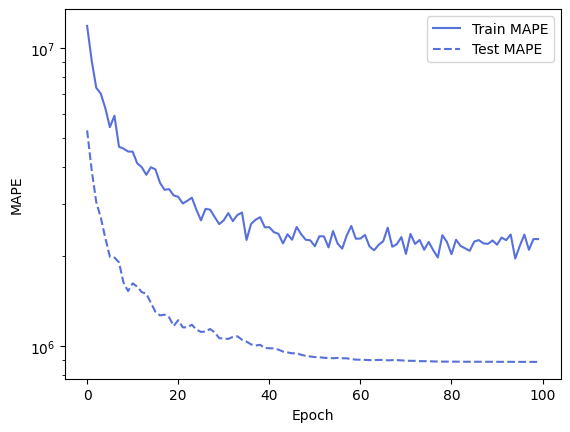

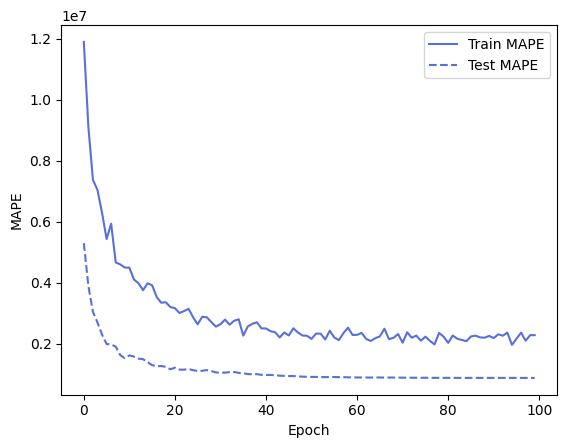

In [69]:
train_mape = history.history['mape']
test_mape = history.history['val_mape']

# Plot training and validation MSE for the current fold
plt.plot(train_mape, label=f'Train MAPE',color=colors[5])
plt.plot(test_mape, label=f'Test MAPE',color=colors[5],linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.yscale('log')
# plt.title('MAPE History')
plt.legend()
plt.show()


# Plot training and validation MSE for the current fold
plt.plot(train_mape, label=f'Train MAPE',color=colors[5])
plt.plot(test_mape, label=f'Test MAPE',color=colors[5],linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
# plt.title('MAPE History')
plt.legend()
plt.show()

In [70]:
predicted_values = best_model.predict(X_train_prepared)[:, 0]>0
actual_values = np.array(y_train["profit_part_budget"])>0

matches = np.sum(predicted_values == actual_values)
print("The accuracy on the training set is ",str(round(matches*100/len(X_train_prepared),2))+"%")

predicted_values = best_model.predict(X_test_prepared)[:, 0]>0
actual_values = np.array(y_test["profit_part_budget"])>0

matches = np.sum(predicted_values == actual_values)
print("The accuracy on the training set is ",str(round(matches*100/len(X_train_prepared),2))+"%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


The accuracy on the training set is  50.32%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy on the training set is  8.97%


In [71]:
avg_values=list(pd.concat([dataset_train_preprocessed,dataset_test_preprocessed])[y_test.columns].mean())
[f'{avg:.2e}' for avg in avg_values]

['1.56e+00',
 '4.42e+01',
 '1.99e+08',
 '1.76e+08',
 '9.48e+02',
 '6.28e+00',
 '1.79e+00']

In [72]:
med_values=list(pd.concat([dataset_train_preprocessed,dataset_test_preprocessed])[y_test.columns].median())
[f'{med:.2e}' for med in med_values]

['2.00e+00',
 '1.54e+00',
 '8.69e+07',
 '8.21e+07',
 '4.40e+02',
 '6.30e+00',
 '1.15e+00']

In [73]:
mse=mean_squared_error(best_model.predict(X_test_prepared),y_test,multioutput='raw_values')

predictions = best_model.predict(X_test_prepared)

medae = np.median(np.abs(y_test - predictions), axis=0)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [74]:
df_mean["Neural Network regressor"]=mse
df_median["Neural Network regressor"]=medae

In [88]:
list_abbrev=["Ada","OLS","BL","DTm","DTs","GB","KN","RFm","RFs","NN"]

l_recap=[]
i=0
for target in df_mean.index:
    l=[]
    l.append(target)
    l.append(avg_values[i])
    l.append(list_abbrev[list(df_mean.columns).index(df_mean.transpose()[df_mean.transpose()[target]==df_mean.transpose().min()[target]].index[0])])
    l.append(df_mean.transpose().min()[target])
    l.append(df_mean.loc[target]["Baseline OLS"])
    l.append(df_mean.loc[target]["Baseline mean"])
    l.append(list_abbrev[list(df_mean.columns).index(df_median.transpose()[df_median.transpose()[target]==df_median.transpose().min()[target]].index[0])])
    l.append(df_median.transpose().min()[target])
    l.append(df_median.loc[target]["Baseline OLS"])
    l.append(df_median.loc[target]["Baseline mean"])
    # print(target,list_abbrev[list(df_mean.columns).index(df_mean.transpose()[df_mean.transpose()[target]==df_mean.transpose().min()[target]].index[0])])
    # print(target,list_abbrev[list(df_median.columns).index(df_mean.transpose()[df_median.transpose()[target]==df_median.transpose().min()[target]].index[0])])
    # print(l)
    print(l)
    l_recap.append(l)
    i+=1

df_recap=pd.DataFrame(l_recap)
# df_recap.to_csv("raw_recap.csv")

['profit_groups', 1.5598755832037325, 'Ada', 0.7875647668393783, 0.9948186528497408, 1.212435233160622, 'Ada', 1.0, 1.0, 1.0]
['profit_part_budget', 44.22866720585132, 'DTs', 535.7105008465501, 8371.492418135369, 3026.691151848436, 'DTs', 1.5421818277920318, 65.66980896, 49.17590425065482]
['revenue_adj', 199282791.61181352, 'KN', 4.213968226889541e+16, 5.4691632503312456e+16, 8.916535664613413e+16, 'KN', 60234665.35377157, 61675970.83253901, 157757184.1003378]
['revenue', 176328509.38569206, 'KN', 4.858222645142896e+16, 5.3159017151107656e+16, 1.0922437036455342e+17, 'Ada', 42378880.58544304, 57993523.0, 133047507.12534308]
['vote_count', 947.9533437013997, 'OLS', 1045725.7772020726, 1045725.7772020726, 2215628.072912947, 'OLS', 383.0, 383.0, 665.4967978042087]
['vote_average', 6.2800933125972005, 'RFs', 0.6429629192460317, 0.6907101661800719, 0.7821674046284891, 'DTs', 0.549090909090908, 0.6218750000000002, 0.6483074107959741]
['popularity', 1.7874028856920683, 'Ada', 17.491012180951

In [89]:
df_recap.columns=["Target","Avg","Type1","Score","OLS","BL","Type2","Score","OLS","BL"]
df_recap["Target"]=y_test.columns
df_recap["Target"]=df_recap["Target"].apply(lambda  x : "$"+x.replace("_","\_")+"$")
df_recap["Type1"]=df_recap["Type1"].apply(lambda  x : "\\textbf{"+x+"}$^\dag$")
df_recap["Type2"]=df_recap["Type2"].apply(lambda  x : "\\textbf{"+x+"}$^\dag$")
df_recap.columns=["Target","Avg","Type","Score","OLS","BL","Type","Score","OLS","BL"]
df_recap.to_csv("recap_tab.csv",sep="&",float_format='%.2e')

C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3298526407.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(y_test.columns,rotation=45)
C:\Users\rapha\AppData\Local\Temp\ipykernel_41120\3298526407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(y_test.columns,rotation=45)


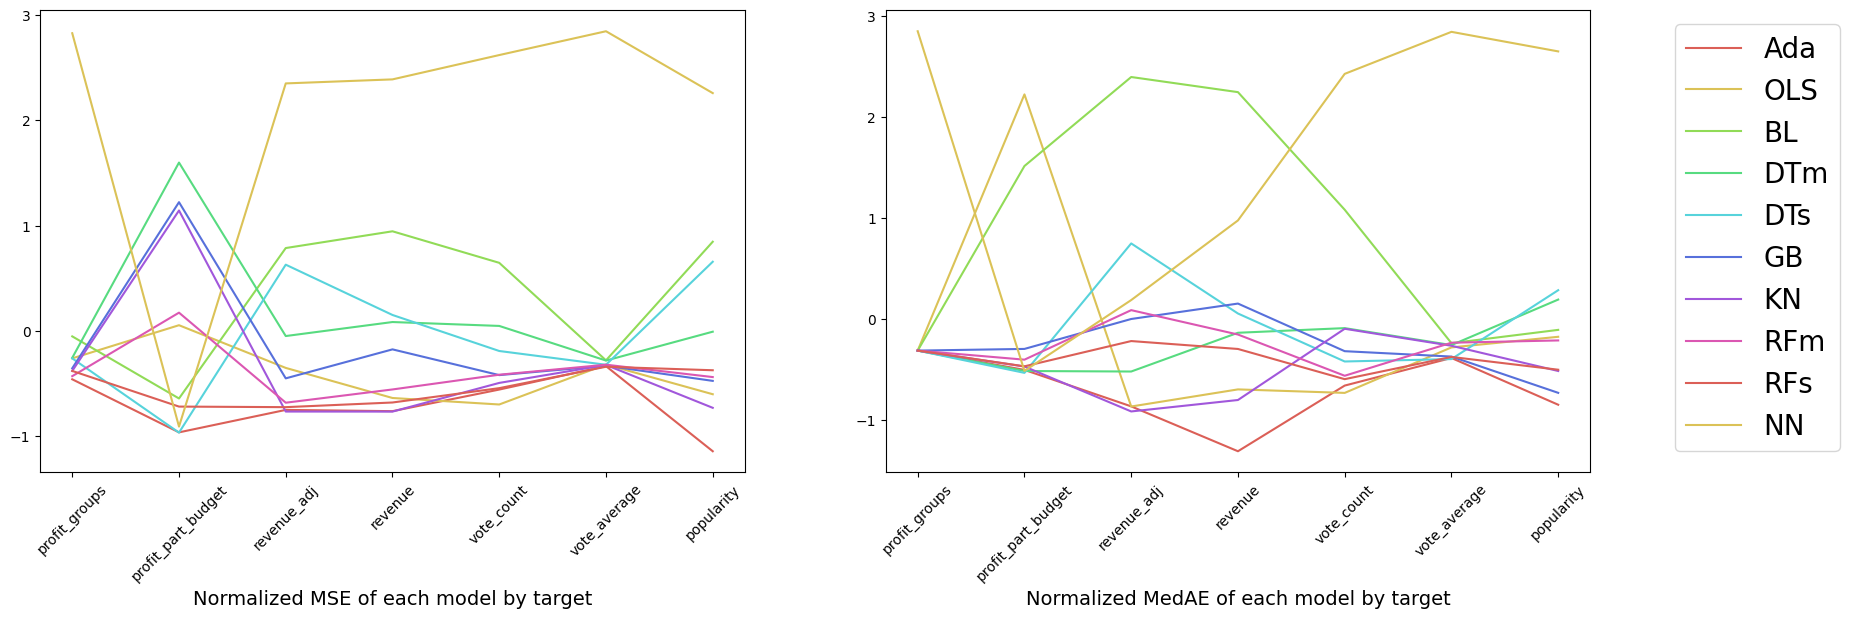

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.set_palette(sns.color_palette("hls", 11))
labels=["Ada","OLS","BL","DTm","DTs","GB","KN","RFm","RFs","NN"]
plt.rc('font', size=20)
i=0
for model in df_mean.columns:
    df_res_temp=df_mean.transpose()
    df_res_temp=(df_res_temp-df_res_temp.mean())/df_res_temp.std()
    df_res_temp=df_res_temp.transpose()
    axes[0].plot(df_res_temp.index,df_res_temp[model],label=labels[i])
    
    i+=1
    
i=0
for model in df_median.columns:
    df_median_temp=df_median.transpose()
    df_median_temp=(df_median_temp-df_median_temp.mean())/df_median_temp.std()
    df_median_temp=df_median_temp.transpose()
    axes[1].plot(df_median_temp.index,df_median_temp[model],label=labels[i])
    
    i+=1

axes[0].set_xlabel("Normalized MSE of each model by target",fontsize=14)    
axes[1].set_xlabel("Normalized MedAE of each model by target",fontsize=14)

axes[0].set_xticklabels(y_test.columns,rotation=45)
axes[1].set_xticklabels(y_test.columns,rotation=45)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()
plt.rc('font', size=10)

The results are so bad using a dense neural network that it seems more interesting to plot in the report the normalized values without the NN curve.

## Split influence

The dataset is split respecting the release date i.e. all movies in the test dataset were released after all the movies from the train dataset. For the previous analysis, we chose a ratio of 15% of the dataset for the train dataset. In this section, we will see how the splitting ratio influences the performances.
We use the MedAE metric to choose the best models for each target and we keep the same model for each split.

In [91]:
dataset_train_preprocessed_15=pd.read_csv("dataset_train_15.csv")
dataset_test_preprocessed_15=pd.read_csv("dataset_test_15.csv")

dataset_train_preprocessed_25=pd.read_csv("dataset_train_25.csv")
dataset_test_preprocessed_25=pd.read_csv("dataset_test_25.csv")

dataset_train_preprocessed_35=pd.read_csv("dataset_train_35.csv")
dataset_test_preprocessed_35=pd.read_csv("dataset_test_35.csv")


def aux (month):
    if month in [5,6]:
        return(1)
    elif month in [9,10]:
        return(-1)
    else:
        return(0)
    
def process(dataset_train,dataset_test,training_features=training_features,cat_cols=cat_cols):
    cat_cols_loc=cat_cols[:-1]
    training_features_loc=training_features[:-1]

    dataset_train["release_period"]=dataset_train["release_month"].apply(aux)
    dataset_test["release_period"]=dataset_test["release_month"].apply(aux)
    dataset_train["profit_part_budget"]=dataset_train["profit"]/dataset_train["budget"]
    dataset_test["profit_part_budget"]=dataset_test["profit"]/dataset_test["budget"]
    preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols_loc),
                                    ('num', StandardScaler(), num_cols)])
    
    X_train_proc = preprocessor.fit_transform(dataset_train[training_features_loc])
    X_test_proc = preprocessor.transform(dataset_test[training_features_loc])

    kmeans = KMeans(n_clusters=8, init='k-means++')
    kmeans.fit(X_train_proc)
    dataset_train["cluster"]=kmeans.predict(X_train_proc)
    dataset_test["cluster"]=kmeans.predict(X_test_proc)
    training_features_loc.append("cluster")
    cat_cols_loc.append("cluster")
    preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols_loc),
                                    ('num', StandardScaler(), num_cols)])
    X_train_proc = preprocessor.fit_transform(dataset_train[training_features_loc])
    X_test_proc = preprocessor.transform(dataset_test[training_features_loc])

    y_test_proc = dataset_test[target_feature]
    y_train_proc = dataset_train[target_feature]

    return(X_train_proc,y_train_proc,X_test_proc,y_test_proc)

X_train_15,y_train_15,X_test_15,y_test_15=process(dataset_train_preprocessed_15,dataset_test_preprocessed_15)
X_train_25,y_train_25,X_test_25,y_test_25=process(dataset_train_preprocessed_25,dataset_test_preprocessed_25)
X_train_35,y_train_35,X_test_35,y_test_35=process(dataset_train_preprocessed_35,dataset_test_preprocessed_35)

In [92]:
targets=['profit_groups', 'profit_part_budget', 'revenue_adj', 'revenue',
       'vote_count', 'vote_average', 'popularity']

models_split={}
mse_split={}
medae_split={}
for target in targets :
       mse_split[target]=[]
       medae_split[target]=[]



with open(FOLDER_MODELS+'/'+"Random Forest"+' '+'multi'+'.pkl', 'rb') as f:
       target='profit_groups'
       ref_model= pickle.load(f)

       models_split[target]=RandomForestRegressor(random_state=0,n_jobs=16,criterion="friedman_mse",max_depth=ref_model.max_depth,n_estimators=ref_model.n_estimators,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_35,y_train_35)
       res_multi=models_split[target].predict(X_test_35)
       res_multi=res_multi[:,0].round()
       mse_split[target].append(mean_squared_error(res_multi,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res_multi-y_test_35[target]),axis=0))

       models_split[target]=RandomForestRegressor(random_state=0,n_jobs=16,criterion="friedman_mse",max_depth=ref_model.max_depth,n_estimators=ref_model.n_estimators,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_25,y_train_25)
       res_multi=models_split[target].predict(X_test_25)
       res_multi=res_multi[:,0].round()
       mse_split[target].append(mean_squared_error(res_multi,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res_multi-y_test_25[target]),axis=0))

       models_split[target]=RandomForestRegressor(random_state=0,n_jobs=16,criterion="friedman_mse",max_depth=ref_model.max_depth,n_estimators=ref_model.n_estimators,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_15,y_train_15)
       res_multi=models_split[target].predict(X_test_15)
       res_multi=res_multi[:,0].round()
       mse_split[target].append(mean_squared_error(res_multi,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res_multi-y_test_15[target]),axis=0))


with open(FOLDER_MODELS+'/'+"Decision Tree"+' '+"profit_part_budget"+'.pkl', 'rb') as f:
       target='profit_part_budget'
       ref_model= pickle.load(f)

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_35,y_train_35[target])
       res=models_split[target].predict(X_test_35)
       mse_split[target].append(mean_squared_error(res,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_25,y_train_25[target])
       res=models_split[target].predict(X_test_25)
       mse_split[target].append(mean_squared_error(res,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_prepared,y_train_15[target])
       res=models_split[target].predict(X_test_15)
       mse_split[target].append(mean_squared_error(res,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

with open(FOLDER_MODELS+'/'+"K-Neighbors"+' '+"revenue_adj"+'.pkl', 'rb') as f:
       target='revenue_adj'
       ref_model= pickle.load(f)

       models_split[target]=KNeighborsRegressor(n_jobs=16,weights=ref_model.weights,n_neighbors=ref_model.n_neighbors)
       models_split[target].fit(X_train_35,y_train_35[target])
       res=models_split[target].predict(X_test_35)
       mse_split[target].append(mean_squared_error(res,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

       models_split[target]=KNeighborsRegressor(n_jobs=16,weights=ref_model.weights,n_neighbors=ref_model.n_neighbors)
       models_split[target].fit(X_train_25,y_train_25[target])
       res=models_split[target].predict(X_test_25)
       mse_split[target].append(mean_squared_error(res,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

       models_split[target]=KNeighborsRegressor(n_jobs=16,weights=ref_model.weights,n_neighbors=ref_model.n_neighbors)
       models_split[target].fit(X_train_prepared,y_train_15[target])
       res=models_split[target].predict(X_test_15)
       mse_split[target].append(mean_squared_error(res,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

with open(FOLDER_MODELS+'/'+"Adaboost"+' '+"revenue"+'.pkl', 'rb') as f:
       target='revenue'
       ref_model= pickle.load(f)

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_35,y_train_35[target])
       res=models_split[target].predict(X_test_35)
       mse_split[target].append(mean_squared_error(res,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_25,y_train_25[target])
       res=models_split[target].predict(X_test_25)
       mse_split[target].append(mean_squared_error(res,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_prepared,y_train_15[target])
       res=models_split[target].predict(X_test_15)
       mse_split[target].append(mean_squared_error(res,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

target="vote_count"
models_split[target]=LinearRegression()
models_split[target].fit(X_train_35,y_train_35[target])
res=models_split[target].predict(X_test_35)
mse_split[target].append(mean_squared_error(res,y_test_35[target]))
medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

models_split[target]=LinearRegression()
models_split[target].fit(X_train_25,y_train_25[target])
res=models_split[target].predict(X_test_25)
mse_split[target].append(mean_squared_error(res,y_test_25[target]))
medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

models_split[target]=LinearRegression()
models_split[target].fit(X_train_15,y_train_15[target])
res=models_split[target].predict(X_test_15)
mse_split[target].append(mean_squared_error(res,y_test_15[target]))
medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

with open(FOLDER_MODELS+'/'+"Decision Tree"+' '+"vote_average"+'.pkl', 'rb') as f:
       target='vote_average'
       ref_model= pickle.load(f)

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_35,y_train_35[target])
       res=models_split[target].predict(X_test_35)
       mse_split[target].append(mean_squared_error(res,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_25,y_train_25[target])
       res=models_split[target].predict(X_test_25)
       mse_split[target].append(mean_squared_error(res,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

       models_split[target]=DecisionTreeRegressor(random_state=0,criterion="friedman_mse",max_depth=ref_model.max_depth,min_samples_split=ref_model.min_samples_split,min_samples_leaf=ref_model.min_samples_leaf,max_features=ref_model.max_features)
       models_split[target].fit(X_train_prepared,y_train_15[target])
       res=models_split[target].predict(X_test_15)
       mse_split[target].append(mean_squared_error(res,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

with open(FOLDER_MODELS+'/'+"Adaboost"+' '+"popularity"+'.pkl', 'rb') as f:
       target='popularity'
       ref_model= pickle.load(f)

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_35,y_train_35[target])
       res=models_split[target].predict(X_test_35)
       mse_split[target].append(mean_squared_error(res,y_test_35[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_35[target])))

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_25,y_train_25[target])
       res=models_split[target].predict(X_test_25)
       mse_split[target].append(mean_squared_error(res,y_test_25[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_25[target])))

       models_split[target]=AdaBoostRegressor(random_state=0,n_estimators=ref_model.n_estimators,loss=ref_model.loss,learning_rate=ref_model.learning_rate)
       models_split[target].fit(X_train_prepared,y_train_15[target])
       res=models_split[target].predict(X_test_15)
       mse_split[target].append(mean_squared_error(res,y_test_15[target]))
       medae_split[target].append(np.median(np.abs(res-y_test_15[target])))

In [93]:
df_split_mse=pd.DataFrame(mse_split)
df_split_mse=(df_split_mse-df_split_mse.std())/df_split_mse.mean()
df_split_medae=pd.DataFrame(medae_split)
df_split_medae=(df_split_medae-df_split_medae.std())/df_split_medae.mean()

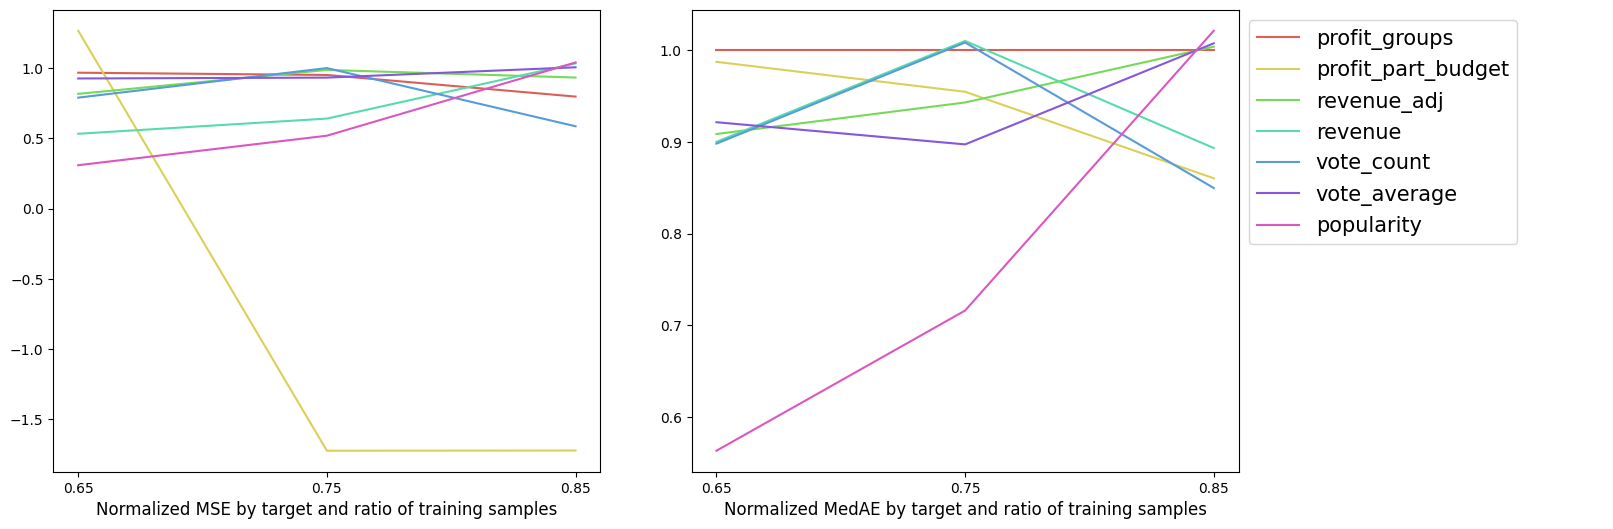

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),width_ratios=[0.4,0.4,0.2])
colors = sns.color_palette("hls", len(targets))
plt.rc('font', size=15)

axes[0].set_xlabel("Normalized MSE by target and ratio of training samples",fontsize=12)    
axes[1].set_xlabel("Normalized MedAE by target and ratio of training samples",fontsize=12)

i = 0
for col in df_split_mse.columns:
    axes[0].plot(["0.65", "0.75", "0.85"], df_split_mse[col], color=colors[i], label=col)
    axes[1].plot(["0.65", "0.75", "0.85"], df_split_medae[col],color=colors[i],label=col)
    i += 1



# Hide the axes for the legend subplot
axes[2].axis('off')

# Add legend to the legend subplot
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()
plt.rc('font', size=10)


It is interesting to see that not every target has error prediction metrics' values that decrease with the ratio of training samples. In particular, the MedAE of the popularity related attributes "popularity" and "vote_average" increase with the number of training samples.

## Classification

First we try to predict the profit group using the regressors. For that, we round the predictions to the nearest integer and we use as predictor the best predictor for the profit_groups attribute (for the MAE metric since all regressors had the same MedAE).

In [103]:
from sklearn.metrics import classification_report,confusion_matrix

c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetric

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.49      0.83      0.62        60
           2       0.22      0.42      0.29        40
           3       0.83      0.15      0.26        66

    accuracy                           0.40       193
   macro avg       0.38      0.35      0.29       193
weighted avg       0.48      0.40      0.34       193



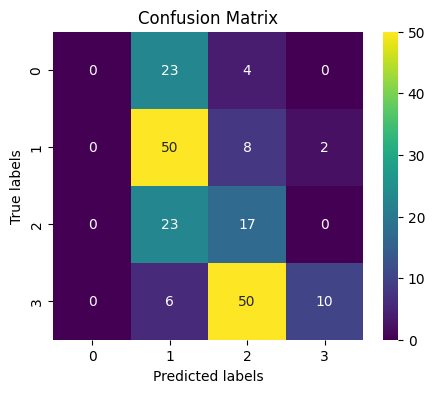

In [104]:
pred=dic_best_estimators_ensembles["Adaboost"][0]["profit_groups"].predict(X_test_prepared).round().astype(int)
class_report=classification_report(y_test["profit_groups"], pred)
print(class_report)

# pred=dic_best_estimators_ensembles["Adaboost"][0]["profit_groups"].predict(X_train_prepared).round().astype(int)
# print(classification_report(y_train["profit_groups"], pred))
#print(confusion_matrix(y_test1, idx))
cm = confusion_matrix(y_test["profit_groups"], pred)

fig, ax= plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

As we will see later, the problem that makes profitability prediction impossible also remains for profit group since no sample is predicted to be non profitable due to the unbalancement of the dataset.

In [105]:
report_data = []
lines = class_report.split('\n')
for line in lines[2:-3]:
    row_data = line.split()
    if len(row_data) == 5:
        row = {
            "class": row_data[0],
            "precision": float(row_data[1]),
            "recall": float(row_data[2]),
            "f1-score": float(row_data[3]),
            "support": int(row_data[4])
        }
        report_data.append(row)

df = pd.DataFrame(report_data)

# Save DataFrame to CSV
df.to_csv("classification_report.csv",sep="&", index=False)

### Method and references

Similarly, we will use the classification version of the following models: 
- Decision Trees
- Random Forests
- Gradient Boosting Decision Trees
- Adaboost

For each target numerical attribute, to have a reference in terms of performance, we will compare the results to :
- a naiv baseline that returns the most present class for each target

Besides, we will compare the multiple targets decision trees from scikit learn with the typical single target decision trees.

### Gridsearch

This section presents the code used for classification on the profitability attribute. The section is only left to show the effort made but the results obtained were systematically worse than the baseline.

In [114]:
# Do not run this cell again when changing the type of ensembles, otherwise, you will loose you rresults.
dic_best_estimators_ensembles={}    #(dic_single_target_dt,features_importances_single,multi_target_dt,multi_target_fi)

In [191]:
# Do not run this cell again when changing the type of ensembles, otherwise, you will loose you rresults.
dic_res={}

unique_elements, counts = np.unique(y_train_classification, return_counts=True)
main_class=unique_elements[np.argmax(counts)]
dic_res["Baseline main class"]=[accuracy_score([main_class]*len(y_test_classification),y_test_classification)]


Choose the type of regressor to evaluate (to plot the final comparison, if you want all results, you must have trie all of them). When possible, we use the class_weight parameter since otherwise, due to the unbalancement of the dataset, the classifier turns into a naiv classifier that always returns 1 for the profitability.

In [129]:
Type_of_tree_ensemble="Adaboost"   # "Decision Tree", "Random Forest", "Gradient Boosting", "Adaboost"

if Type_of_tree_ensemble == "Decision Tree":
    tree_regressor=DecisionTreeClassifier(random_state=0,class_weight="balanced")
elif Type_of_tree_ensemble == "Random Forest":
    tree_regressor=RandomForestClassifier(random_state=0,n_jobs=16,class_weight="balanced")
elif Type_of_tree_ensemble=="Gradient Boosting":
    tree_regressor= GradientBoostingClassifier(random_state=0,criterion="friedman_mse") 
elif Type_of_tree_ensemble=="Adaboost":
    tree_regressor= AdaBoostClassifier(random_state=0,estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))


Then, we choose appropriate ranges of hyperparameters to test for the grid search, with specific parameters depending on the chosen type of model.

In [130]:
param_grids={

    "Decision Tree": {
        "criterion":["gini","entropy"],
        'max_depth': [5, 10,20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":[None,"sqrt"]},
    "Random Forest": {
        "criterion":["gini","entropy"],
        "n_estimators":[50,100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]},
    "Gradient Boosting": {
        "n_estimators":[20,50],
         "learning_rate":[0.1,0.5],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":[None,"sqrt"]},
    "Adaboost": {
        "n_estimators":[20,50],
         "learning_rate":[0.1,0.5,1]}}

The use of "neg_mean_squared_error" enables to have best estimators chosen accoriding to their performance in terms of Mean Squared Error (which is the metric used for splitting).

In [131]:
dic_single_target_dt={}     # saving of the best estimator per target
dic_single_target_fi={}     # saving of the feature importances

grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grids[Type_of_tree_ensemble], cv=5, scoring='accuracy')
grid_search.fit(X_train_prepared, y_train_classification)
dic_single_target_dt["profitability"]=grid_search.best_estimator_
dic_single_target_fi["profitability"]=grid_search.best_estimator_.feature_importances_

print("For profitability, the best hyperparameters combination is : ",grid_search.best_params_)

c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\rapha\Documents\CS\NUS_cours\CS5228 Knowledge discovery and data mining\Project\TMDb-Data-Mining\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn

For profitability, the best hyperparameters combination is :  {'learning_rate': 1, 'n_estimators': 50}


### Feature importance

C:\Users\rapha\AppData\Local\Temp\ipykernel_65100\1416663184.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features_importances_single,x="importance",y="feature",palette=sns.color_palette("hls", len(training_features)))


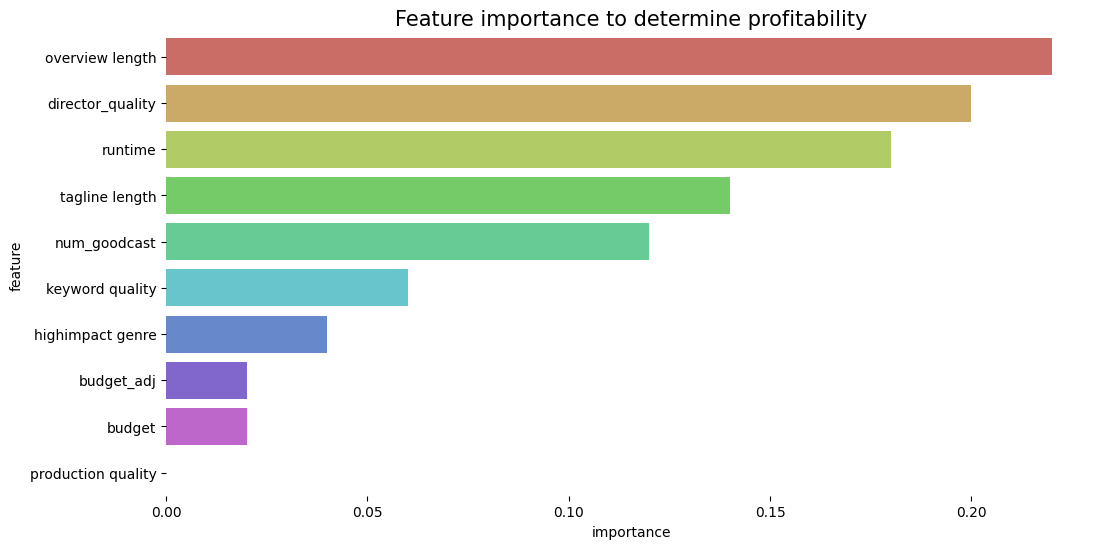

In [132]:
plt.figure(figsize=(12, 6))


features_importances_single=np.array([dic_single_target_fi["profitability"]])

features_importances_single=pd.DataFrame(features_importances_single,columns=training_features)

# features_importances_single=features_importances_single.transpose()
features_importances_single=features_importances_single.transpose().reset_index()
features_importances_single.columns=["feature","importance"]
features_importances_single=features_importances_single.sort_values(by='importance', ascending=False)

sns.barplot(data=features_importances_single,x="importance",y="feature",palette=sns.color_palette("hls", len(training_features)))
sns.despine(left=True, bottom=True)
plt.title('Feature importance to determine profitability', fontsize=15)
plt.show()

Contrary to the regressors, wwe can observe that the feature importance is much more balanced in general for classifiers, even though the top features remain the same.

### First plot of the results

We display the normalized MSE by target and model. The normalization is important to compare the performance of the model among different targets, given that the targets are not normalized.

In [133]:
dic_res

{'Baseline main class': [0.8341968911917098],
 'Decision Tree regressor': [0.6424870466321243],
 'Random Forest regressor': [0.7409326424870466]}

{'Baseline main class': [0.8341968911917098], 'Decision Tree regressor': [0.6424870466321243], 'Random Forest regressor': [0.7409326424870466], 'Adaboost regressor': [0.6528497409326425]}


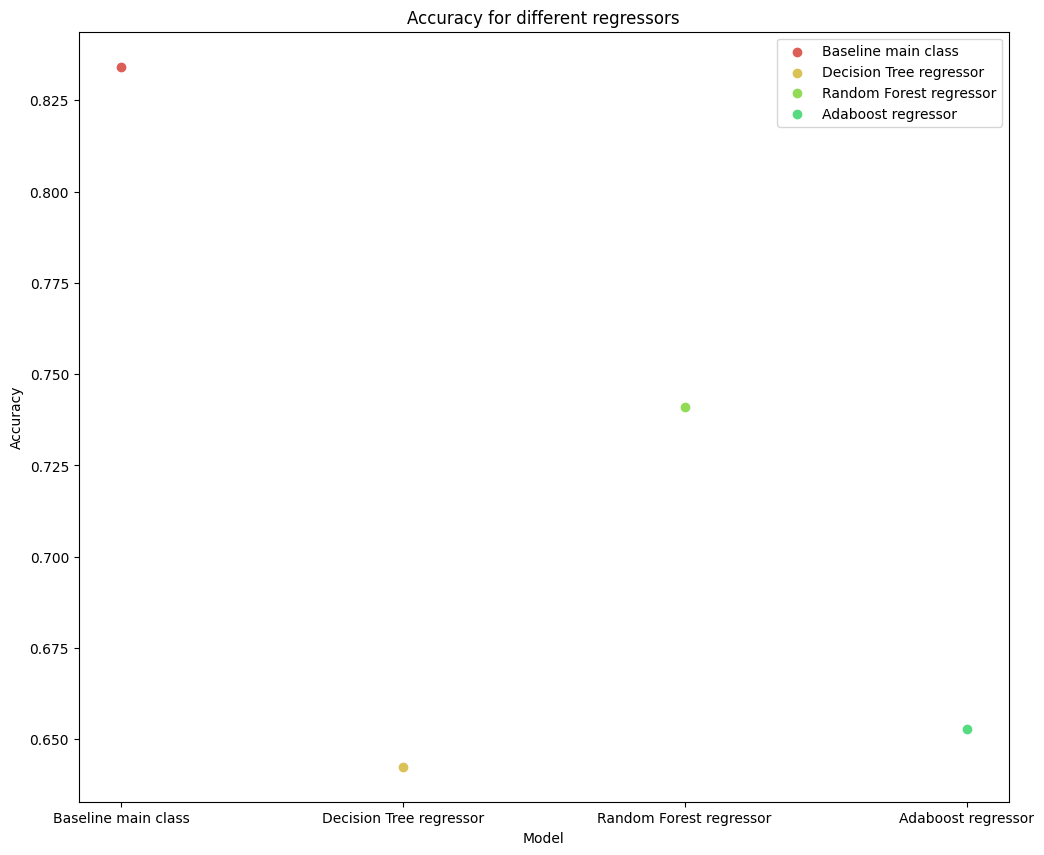

In [134]:
plt.figure(figsize=(12,10))


dic_res[Type_of_tree_ensemble+" regressor"]=[accuracy_score(dic_single_target_dt["profitability"].predict(X_test_prepared),y_test_classification)]

print(dic_res)
df_res=pd.DataFrame(dic_res)

for model in df_res.columns:
    plt.scatter(model, df_res[model],label=model)

plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracy for different regressors')
plt.legend()
plt.show()

We save in a dictionnary the best hyperameters combination for each tree ensemble.

In [127]:
dic_best_estimators_ensembles[Type_of_tree_ensemble]=(dic_single_target_dt,features_importances_single)
dic_best_estimators_ensembles[Type_of_tree_ensemble]=(dic_single_target_dt,features_importances_single)